In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

from matplotlib import colors

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject 

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

from sklearn.cluster import AgglomerativeClustering as AggCluster

import sys
import os

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/'

# roi_2
roi_name = 'roi_2'


# /roi_2

In [3]:
# locations = pd.read_csv(f'{filepath}{roi_name}/exports/cell_attributes_cell_10px_20240605.csv',index_col=0)
# matrix = pd.read_csv(f'{filepath}{roi_name}/exports/cell_by_gene_matrix_20240606_10px_cell.csv',index_col=0)

# matrix.set_index(matrix.index.astype(str),inplace=True)
# locations.set_index(matrix.index.astype(str),inplace=True)

# /Volumes/GRK_001/spatialbarcodes/2024-05-21_mouseexp_expression/projects/roi2/exports/
with open(f'{filepath}{roi_name}/exports/sg_object_20240604_dilate10.pkl', 'rb') as f:
    sg_obj = pickle.load(f)


In [4]:
# set object id (as string) as index

matrix = sg_obj.get_cell_gene_table_df()
matrix['object_id'] = [str(int(x)) for x in matrix['object_id']]
matrix.set_index('object_id',inplace=True)

sg_obj.gdf['object_id'] = [str(int(x)) for x in sg_obj.gdf['object_id']]
sg_obj.gdf.set_index('object_id',inplace=True)

No filtering available or applied.


In [5]:
sg_obj.gdf['nucleus_centroid'] = sg_obj.gdf['nucleus'].centroid.values
sg_obj.gdf['center_x'] = sg_obj.gdf['nucleus'].centroid.x.values
sg_obj.gdf['center_y'] = sg_obj.gdf['nucleus'].centroid.y.values
sg_obj.gdf['area'] = sg_obj.gdf['nucleus_dilated'].area.values

In [6]:
barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]

In [7]:
cutoff = 4

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
# df.set_index('object_id')

df = matrix

# df.sort_index(inplace=True)

df['cell_id'] = df.index

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] > cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)


In [8]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

In [9]:
adata_genes = sc.AnnData(df[gene_cols])

cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes','area','center_x','center_y']
# for col in :
#     adata_genes.obs[col] = df[col]

adata_genes.obs = df[cols]

In [10]:
min_area = 2000

adata_genes = adata_genes[adata_genes.obs['area']>min_area]

In [11]:
# filter cells and genes by number of occurences 
sc.pp.filter_cells(adata_genes, min_genes=15) # keep only cells that have at least 10 genes
sc.pp.filter_genes(adata_genes, min_cells=500) # keep only genes that are expressed in at least 500 cells

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [12]:
total_bc_threshold = 10

# include cells with at least 10 barcode spots
has_bcs = df[df[barcode_cols].sum(axis=1) >= 10]
matrix = has_bcs[barcode_cols]

matrix_norm = matrix.div(matrix.sum(axis=1), axis=0)
braycurtis_dist = scipy.spatial.distance.pdist(matrix_norm,metric='braycurtis')

braycurtis_dist_square = scipy.spatial.distance.squareform(braycurtis_dist)

In [13]:
threshold = 0.4
cluster = AggCluster(distance_threshold=threshold,n_clusters=None,linkage='average',affinity='precomputed').fit(braycurtis_dist_square)

In [14]:
cluster_name_cutoff = 3


obj_clusters = {obj_id:clus for obj_id,clus in zip(matrix.index,cluster.labels_)}

cluster_objects = {}
cluster_barcode_names = {}
cluster_found_barcodes = {}
cluster_n_found_barcodes = {}

for clu in np.unique(cluster.labels_):
    cluster_objects[clu] = matrix.index[cluster.labels_ == clu]

    avg_bc_counts = np.mean(matrix[cluster.labels_ == clu],axis=0)
    # print(avg_bc_counts)
    # break

    found_bcs = []

    for bc in barcode_cols:
        if avg_bc_counts[bc] > cutoff:
            found_bcs.append(bc)

    print(clu,found_bcs)

    cluster_found_barcodes[clu] = found_bcs
    cluster_n_found_barcodes[clu] = len(found_bcs)

    cluster_barcode_names[clu] = '-'.join(sorted(found_bcs))

0 ['bc_091']
1 []
2 ['bc_063', 'bc_066']
3 ['bc_094']
4 []
5 ['bc_003', 'bc_009']
6 ['bc_094']
7 ['bc_001', 'bc_031', 'bc_033', 'bc_087']
8 ['bc_007', 'bc_013', 'bc_054', 'bc_060']
9 ['bc_006', 'bc_018', 'bc_043']
10 ['bc_021', 'bc_049', 'bc_079']
11 ['bc_019', 'bc_025', 'bc_074', 'bc_092']
12 ['bc_074', 'bc_083']
13 ['bc_008', 'bc_040']
14 []
15 ['bc_001', 'bc_024', 'bc_029', 'bc_031', 'bc_066', 'bc_087', 'bc_091']
16 ['bc_040', 'bc_052', 'bc_092', 'bc_093']
17 ['bc_030', 'bc_060']
18 ['bc_060']
19 ['bc_022', 'bc_087']
20 ['bc_026', 'bc_041']
21 ['bc_021', 'bc_028', 'bc_060', 'bc_067', 'bc_074']
22 ['bc_003', 'bc_009', 'bc_066', 'bc_087']
23 ['bc_085']
24 ['bc_024', 'bc_025', 'bc_041']
25 ['bc_031', 'bc_047', 'bc_093']
26 ['bc_008', 'bc_035', 'bc_059', 'bc_063', 'bc_074', 'bc_081']
27 ['bc_066', 'bc_091']
28 ['bc_008', 'bc_041', 'bc_096']
29 ['bc_016']
30 ['bc_002', 'bc_060']
31 ['bc_025', 'bc_079', 'bc_083']
32 ['bc_028', 'bc_092']
33 ['bc_048']
34 ['bc_060']
35 ['bc_049', 'bc_079']


In [15]:
adata_genes.obs['bc_cluster'] = [obj_clusters[obj_id] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_n_bcs'] = [cluster_n_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_found_bcs'] = [cluster_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_bc_names'] = [cluster_barcode_names[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]

In [16]:


triple_bc_clusters = adata_genes.obs[adata_genes.obs['bc_cluster_n_bcs'] >= 3]    

cs,counts = np.unique([int(x) for x in triple_bc_clusters['bc_cluster'].values],return_counts=True)

cs[np.argsort(counts)[::-1]]

array([ 311,  372,   91, 1214,   39, 1096,  512,  238, 1114,  644,   31,
        277, 1101,  256,  332,    8,  258,   71,   72,   78,   42,  161,
         92, 1394,   26,  100,  208,  448,  157,  412,  109,   97,  910,
        746,  617, 1020,  538,   55,  965,   28,  564,  176,  756,  195,
         16, 1534,  186,  753,  927,  356,   10, 3176,   49,  481,  155,
        846, 1510,  511,  431,  228,  250,   57, 1408,  396, 1080,  894,
       1254,  651,  684, 1590,  175, 1383,  335,  632, 1315,  863,  539,
        381,  622,   22,  204,  213,  338,  321, 1511, 1522,  344, 1190,
        196,  279,  331,   93,  527,  318,  339,  329,  325,  599,  247,
        300,  255, 1677,  888,  411,  795,  293,  652, 1692, 1442,  394,
        748,  818,   47, 1666,  620,  112,  567,   83,   41,  783,  605,
        222,  438,  371,  467,  454, 1401, 1072,  446, 1820,  981,  407,
       1228, 1148, 2616,  360, 1112,  319, 1404,  309,  232,  167,  340,
        525, 1646,  551, 1658,  127,  889, 1561,  8

In [17]:
clusters_to_show = []

for clu,count in zip(cs[np.argsort(counts)[::-1]],counts[np.argsort(counts)[::-1]]):
    if count > 20:
        clusters_to_show.append(clu)
        print(clu,count,cluster_n_found_barcodes[clu],cluster_barcode_names[clu])

311 1388 4 bc_001-bc_029-bc_031-bc_087
372 1150 5 bc_029-bc_059-bc_064-bc_068-bc_085
91 415 3 bc_041-bc_066-bc_093
1214 389 4 bc_025-bc_060-bc_062-bc_066
39 374 5 bc_030-bc_058-bc_059-bc_083-bc_095
1096 368 3 bc_009-bc_014-bc_021
512 366 3 bc_028-bc_038-bc_053
238 342 4 bc_019-bc_040-bc_041-bc_052
1114 332 4 bc_041-bc_045-bc_047-bc_052
644 236 4 bc_006-bc_019-bc_064-bc_094
31 195 3 bc_025-bc_079-bc_083
277 187 6 bc_025-bc_039-bc_047-bc_058-bc_076-bc_079
1101 185 3 bc_050-bc_065-bc_089
256 182 4 bc_004-bc_048-bc_066-bc_083
332 177 3 bc_024-bc_048-bc_060
8 172 4 bc_007-bc_013-bc_054-bc_060
258 163 3 bc_001-bc_025-bc_030
71 162 4 bc_021-bc_028-bc_060-bc_067
72 161 3 bc_067-bc_077-bc_087
78 151 3 bc_017-bc_085-bc_087
42 146 3 bc_004-bc_041-bc_077
161 146 4 bc_013-bc_024-bc_082-bc_091
92 138 3 bc_021-bc_058-bc_070
1394 136 3 bc_008-bc_084-bc_086
26 135 6 bc_008-bc_035-bc_059-bc_063-bc_074-bc_081
100 124 4 bc_001-bc_024-bc_031-bc_087
208 112 7 bc_001-bc_003-bc_014-bc_033-bc_060-bc_076-bc_094

(-648.8675447522292, 59258.76371243313, -771.1445560851262, 48869.84452242345)

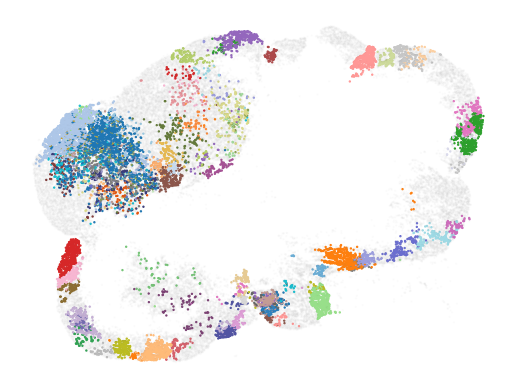

In [18]:
bc_colors = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=len(clusters_to_show))
bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(clusters_to_show)}

bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.02)  for bc in adata_genes.obs['bc_cluster'] ]

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
            c=bc_color_list,
            s=0.5)


plt.axis('off')
# plt.savefig(f'plots/{roi_name}_bc_clusters.pdf',bbox_inches='tight')

In [19]:
adata_genes

AnnData object with n_obs × n_vars = 49625 × 119
    obs: 'cell_id', 'n_called_barcodes', 'barcode_names', 'called_barcodes', 'area', 'center_x', 'center_y', 'n_genes', 'bc_cluster', 'bc_cluster_n_bcs', 'bc_cluster_found_bcs', 'bc_cluster_bc_names'
    var: 'n_cells'

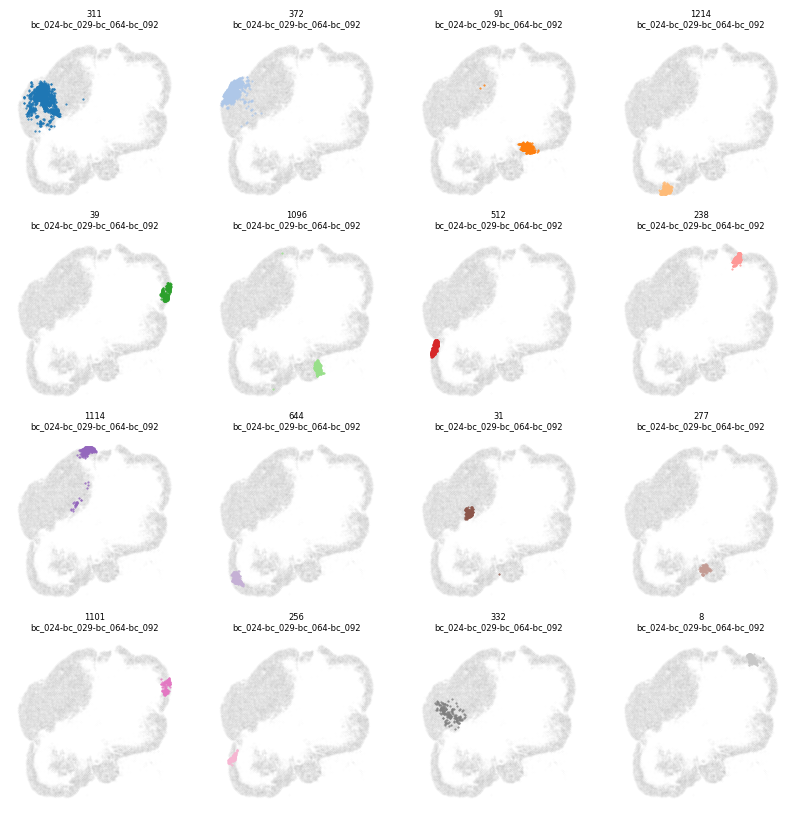

In [20]:
plt.figure(figsize=(10,10))
for i,cluster_name in enumerate(clusters_to_show[:16]):
    
    plt.subplot(4,4,i+1)
    plt.title(f'{cluster_name}\n{cluster_barcode_names[clu]}'
              ,fontsize=6)

    others = adata_genes[adata_genes.obs['bc_cluster']!=cluster_name]
    plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
            color='gray',alpha=0.01,
            s=0.1)

    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_name]

    plt.scatter(this_cluster.obs['center_x'],this_cluster.obs['center_y'],marker='o',
            color=bc_color_dict[cluster_name],alpha=1.0,
            s=0.25)
    
    plt.axis('off')
    



# bc_colors = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=len(clusters_to_show))
# bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(clusters_to_show)}

# bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.02)  for bc in adata_genes.obs['bc_cluster'] ]

# plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
#             c=bc_color_list,
#             s=0.5)


# plt.axis('off')
# plt.savefig(f'plots/{roi_name}_bc_clusters.pdf',bbox_inches='tight')

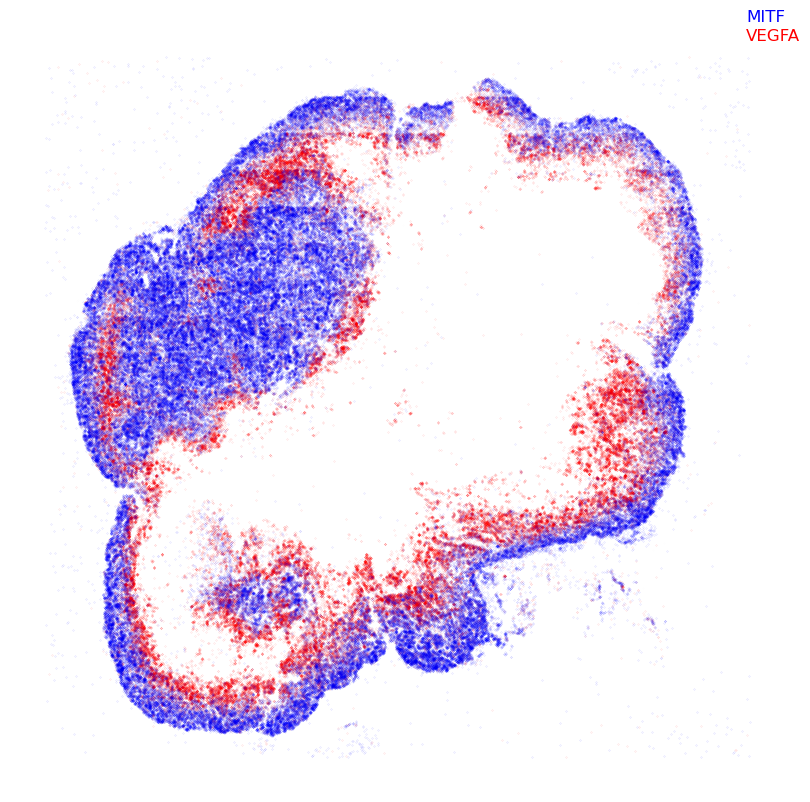

In [21]:
gene_list = ['VEGFA','MITF']
gene_colors = [(1.0,0,0),(0,0,1.0)]

# gene_list = ['VEGFA','COL1A1','MLANA']
# gene_colors = [(1.0,0,0),(0,0,1.0),(0,1,0)]

plt.figure(figsize=(10,10))

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
            color='gray',alpha=0.01,
            s=0.1)

# this_assigned_points_gdf = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['object_id']]
for gene in gene_list:

    this_gene_df = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['name']==gene]
    # this_gene_df = 
    
    plt.scatter(this_gene_df['x'],this_gene_df['y'],marker='.',s=0.1,color=gene_colors[gene_list.index(gene)],alpha=0.3)
    
    plt.axis('off')

plt.text(0.95,0.975,'VEGFA',color='red',fontsize=12,ha='left',transform=plt.gca().transAxes)
plt.text(0.95,1.0,'MITF',color='blue',fontsize=12,ha='left',transform=plt.gca().transAxes)

# plt.savefig(f'plots/VEGFA_COL1A1.png',bbox_inches='tight',dpi=300)
plt.savefig(f'plots/VEGFA_MITF.pdf',bbox_inches='tight',dpi=300)


In [20]:
cell_gene_table_df = sg_obj.get_cell_gene_table_df()
cell_gene_table_df['object_id'] = [str(int(x)) for x in cell_gene_table_df['object_id']]

No filtering available or applied.


238
(342, 222)
(49283, 222)


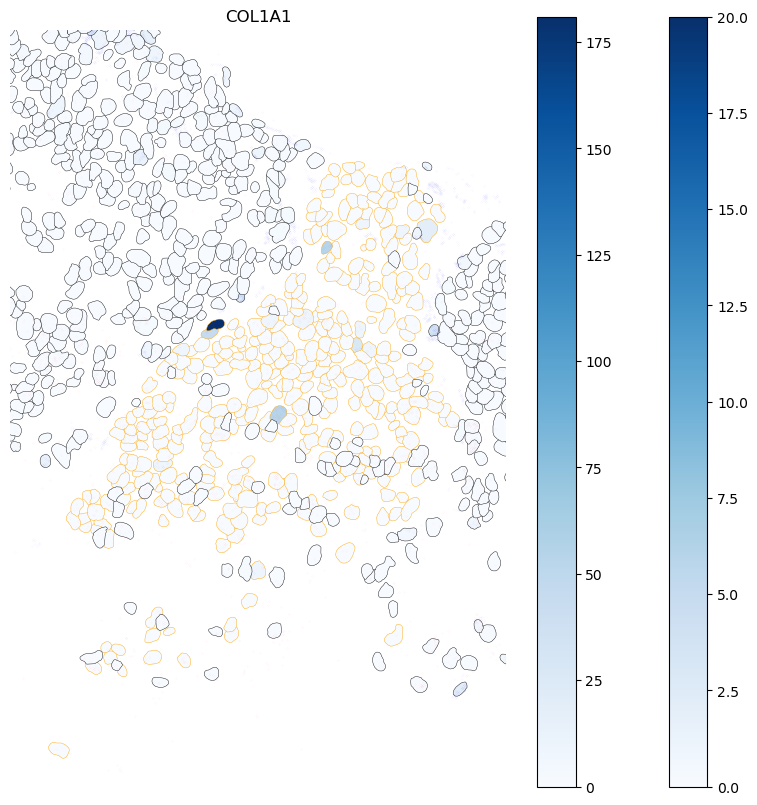

In [23]:
# clusters_of_interest = [311,372]
clusters_of_interest = [238]
# cluster_colors= ['gray','lightgray']
# cluster_colors= ['r','b']
cmaps = ['Blues','Reds']
# cmaps = ['Reds','Blues']

gene_name = 'VEGFA'
gene_name = 'COL1A1'

gene_list = ['VEGFA','COL1A1']
gene_colors = [(1.0,0,0),(0,0,1.0)]

fig, ax = plt.subplots(figsize=(10, 10))
for c,cluster in enumerate(clusters_of_interest):
    print(cluster)
    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster]

    merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')
    
    print(merged_gdf.shape)
    merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=True, ax=ax,edgecolor='orange',linewidth=0.3)

    # merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=True, ax=ax,vmin=40,vmax=100,edgecolor='orange',linewidth=0.3)

# filter to all other clusters
this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')

# plot the other clusters
print(merged_gdf.shape)
merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=True, ax=ax,edgecolor='k',linewidth=0.3)
# merged_gdf.plot(column=gene_name, cmap='Blues', legend=False, ax=ax,vmin=50,vmax=100,edgecolor='k',linewidth=0.05)

ax.set_title(gene_name)
ax.set_aspect('equal')

for gene in gene_list:

    this_gene_df = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['name']==gene]
    # this_gene_df = 
    
    plt.scatter(this_gene_df['x'],this_gene_df['y'],marker='.',s=0.03,color=gene_colors[gene_list.index(gene)],alpha=0.2)
    
    plt.axis('off')


# plt.xlim(0,20000)
# plt.ylim(20000,38000)

plt.xlim(40000,44000)
plt.ylim(39000,45000)


# ax.axis('off')

# plt.savefig(f'plots/{roi_name}_{gene_name}_expression_bc_cluster{clusters_of_interest}.png',bbox_inches='tight',dpi=300)

512
(366, 222)
(49259, 222)


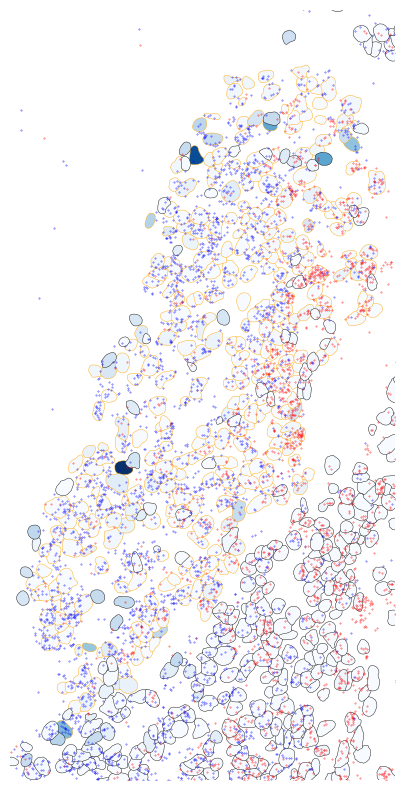

In [24]:
# clusters_of_interest = [311,372]
clusters_of_interest = [238]
clusters_of_interest = [91]
clusters_of_interest = [512]
# cluster_colors= ['gray','lightgray']
# cluster_colors= ['r','b']
cmaps = ['Blues','Reds']
# cmaps = ['Reds','Blues']

# gene_name = 'VEGFA'
# gene_name = 'COL1A1'

# gene_list = ['VEGFA','COL1A1']
gene_list = ['VEGFA','MITF']
gene_colors = [(1.0,0,0),(0,0,1.0)]

fig, ax = plt.subplots(figsize=(10, 10))
for c,cluster in enumerate(clusters_of_interest):
    print(cluster)
    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster]

    merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')
    
    print(merged_gdf.shape)
    merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=False, ax=ax,edgecolor='orange',linewidth=0.3)

    # merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=True, ax=ax,vmin=40,vmax=100,edgecolor='orange',linewidth=0.3)

this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')

print(merged_gdf.shape)
merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=False, ax=ax,edgecolor='k',linewidth=0.3)
# merged_gdf.plot(column=gene_name, cmap='Blues', legend=False, ax=ax,vmin=50,vmax=100,edgecolor='k',linewidth=0.05)

for gene in gene_list:

    this_gene_df = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['name']==gene]
    # this_gene_df = 
    
    plt.scatter(this_gene_df['x'],this_gene_df['y'],marker='.',s=0.5,color=gene_colors[gene_list.index(gene)],alpha=0.7)
    
    # plt.axis('off')

# ax.set_title(gene_name)
ax.set_aspect('equal')


# plt.xlim(0,20000)
# plt.ylim(20000,38000)

# plt.xlim(40000,44000)
# plt.ylim(39000,45000)

# plt.xlim(36000,42000)
# plt.ylim(13000,18000)

plt.xlim(5000,8000)
plt.ylim(12500,18500)


ax.axis('off')

# plt.savefig(f'plots/{roi_name}_{gene_list}_expression_bc_cluster{clusters_of_interest}.png',bbox_inches='tight',dpi=300)

372
(1150, 222)
(48475, 222)


(0.0, 12000.0, 26000.0, 38000.0)

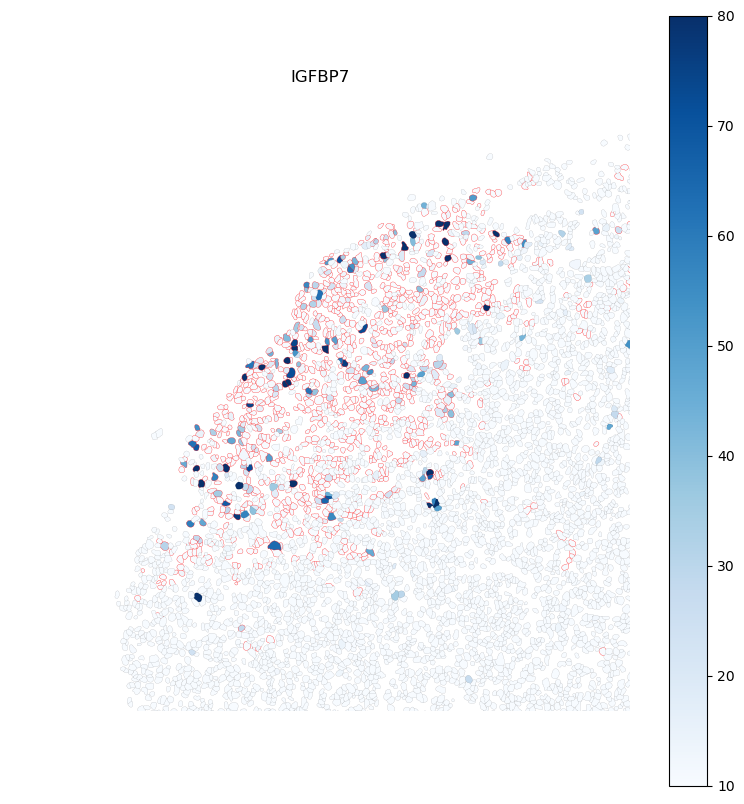

In [25]:

clusters_of_interest = [372]
cmaps = ['Blues','Reds']

gene_name = 'IGFBP7'

fig, ax = plt.subplots(figsize=(10, 10))
for c,cluster in enumerate(clusters_of_interest):
    # filter to just this cluster
    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster]

    merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')

    merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=True, ax=ax,vmin=10,vmax=80,edgecolor='r',linewidth=0.2)

# all other clusters 
this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')

merged_gdf.plot(column=gene_name, cmap='Blues', legend=False, ax=ax,vmin=10,vmax=80,edgecolor='k',linewidth=0.05)

ax.set_title(gene_name)
ax.set_aspect('equal')


# plt.xlim(0,20000)
# plt.ylim(20000,38000)

plt.xlim(0,12000)
plt.ylim(26000,38000)

ax.axis('off')

# plt.savefig(f'plots/{roi_name}_{gene_name}_expression_bc_cluster{clusters_of_interest}.png',bbox_inches='tight',dpi=300)

In [1]:
sg_obj.gdf

NameError: name 'sg_obj' is not defined

In [ ]:
sg_obj.gdf.plot(color='b')

In [21]:
fractions = []
hi_clus = []

hi_clu_dict = {}

gene_cutoff = 25


cell_ids_high = df[df['IGFBP7'] > cutoff]['cell_id']

clus,counts = np.unique(adata_genes[adata_genes.obs['cell_id'].isin(cell_ids_high)].obs['bc_cluster'].values,return_counts=True)
for (bc_clu,hi_count) in zip(clus,counts):
    if ~np.isnan(bc_clu):
        # print(bc_clu)
        all_count = len(adata_genes[adata_genes.obs['bc_cluster']==bc_clu])
        if all_count > 10:
            hi_clus.append(bc_clu)
            fractions.append(hi_count/all_count)
            hi_clu_dict[bc_clu] = hi_count/all_count


In [22]:
all_clus, all_counts = np.unique(adata_genes.obs['bc_cluster'],return_counts = True)

clus_of_interest = []
for clu,count in zip(all_clus,all_counts):
    if count > 5:
        clus_of_interest.append(clu)


In [23]:
big_clus = adata_genes[adata_genes.obs['bc_cluster'].isin(clus_of_interest)]

# big_clus[big_clus['']]

# fraction_here = len

Text(0.5, 0, 'Clone')

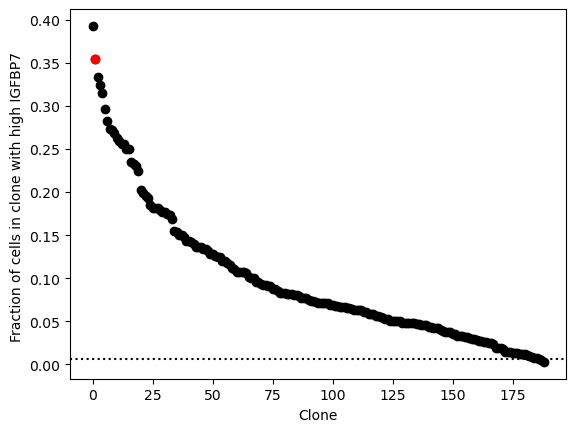

In [24]:
sorted_fractions = sorted

plt.scatter(range(len(fractions)),np.asarray(fractions)[np.argsort(fractions)[::-1]],color='k')
plt.scatter([1],np.asarray(fractions)[np.argsort(fractions)[::-1]][1],color='r')
plt.axhline(len(df[df['IGFBP7']>25].values)/len(df),color='k',linestyle=':')

plt.ylabel('Fraction of cells in clone with high IGFBP7 ')
plt.xlabel('Clone')

# plt.savefig('plots/fraction_of_IGFPB7_spots.pdf')

In [25]:
clus,counts = np.unique(adata_genes.obs['bc_cluster'].values,return_counts=True)

cluster_counts = {clu:count for (clu,count) in zip(clus,counts)}

In [26]:
# determine whether IGFBP7 high cells are enriched per clone.

hi_cluster,hi_counts = np.unique(adata_genes[adata_genes.obs['cell_id'].isin(cell_ids_high)].obs['bc_cluster'].values,return_counts=True)
all_cluster,all_counts =  np.unique(adata_genes.obs['bc_cluster'].values,return_counts=True)


In [27]:
fractions = []

for clu, all_count in zip(all_cluster,all_counts):
    if clu in hi_cluster:
        if all_count > 10:
            fractions.append(hi_counts[np.where(hi_cluster==clu)[0][0]]/all_count)
    else:
        if all_count > 10:
            fractions.append(0)

In [28]:
fractions

[0.04377104377104377,
 0.23255813953488372,
 0.061224489795918366,
 0.15517241379310345,
 0.15384615384615385,
 0.08695652173913043,
 0.08148148148148149,
 0.025,
 0.02666666666666667,
 0,
 0.1076923076923077,
 0.12566844919786097,
 0.07692307692307693,
 0.0821917808219178,
 0.07142857142857142,
 0.012987012987012988,
 0.1276595744680851,
 0.05,
 0.09210526315789473,
 0.029411764705882353,
 0.04594594594594595,
 0.2631578947368421,
 0.05583756345177665,
 0.09259259259259259,
 0.049689440993788817,
 0.013245033112582781,
 0,
 0.23076923076923078,
 0.02564102564102564,
 0,
 0.1320754716981132,
 0.03855421686746988,
 0,
 0.05263157894736842,
 0,
 0.011764705882352941,
 0.012269938650306749,
 0.08064516129032258,
 0,
 0.029850746268656716,
 0.1956521739130435,
 0,
 0.14285714285714285,
 0,
 0.03225806451612903,
 0,
 0.07142857142857142,
 0.18518518518518517,
 0.03007518796992481,
 0.008928571428571428,
 0.12,
 0.045454545454545456,
 0.07216494845360824,
 0.042879019908116385,
 0,
 0.198630

In [29]:
np.array(all_cluster)[np.argsort(fractions)[::-1]]

array([132., 215., 112., 158., 150.,  90., 197., 269., 238., 157.,  21.,
        75., 234.,  78.,  60., 226.,  98.,   1.,  27., 200.,  91.,  55.,
        40., 249.,  47., 201., 192., 274., 176.,  87., 246., 160., 217.,
       146.,   3.,   4., 142.,  69., 134.,  42., 262., 144., 281., 119.,
        77.,  73., 250.,  71.,  30.,  83.,  16.,  11., 148., 141., 242.,
        50., 104., 280., 106., 245.,  10., 189.,  63., 102.,  59., 169.,
       164., 196., 247., 121., 199.,  23.,  18.,  93., 271.,  70.,   5.,
        86., 276., 248.,  58.,  13.,   6., 233.,  37., 213., 159., 175.,
       209.,  12., 204., 216.,  81.,  52.,  67.,  46., 171., 151.,  14.,
       210., 257., 115., 181., 275., 136.,  79., 221., 166., 187., 103.,
       265.,  94., 282.,   2.,  65., 219., 212.,  76.,  22., 113., 108.,
       145., 114.,  33., 194., 101.,  95.,  17.,  24.,  64.,  74., 179.,
       105., 268., 253.,  61., 161.,  20., 208.,  51.,   0.,  53., 156.,
       270.,  96., 180.,  31., 190., 239.,  72., 10

In [30]:
np.argsort(fractions)[::-1]

array([132, 215, 112, 158, 150,  90, 197, 269, 238, 157,  21,  75, 234,
        78,  60, 226,  98,   1,  27, 200,  91,  55,  40, 249,  47, 201,
       192, 274, 176,  87, 246, 160, 217, 146,   3,   4, 142,  69, 134,
        42, 262, 144, 281, 119,  77,  73, 250,  71,  30,  83,  16,  11,
       148, 141, 242,  50, 104, 280, 106, 245,  10, 189,  63, 102,  59,
       169, 164, 196, 247, 121, 199,  23,  18,  93, 271,  70,   5,  86,
       276, 248,  58,  13,   6, 233,  37, 213, 159, 175, 209,  12, 204,
       216,  81,  52,  67,  46, 171, 151,  14, 210, 257, 115, 181, 275,
       136,  79, 221, 166, 187, 103, 265,  94, 282,   2,  65, 219, 212,
        76,  22, 113, 108, 145, 114,  33, 194, 101,  95,  17,  24,  64,
        74, 179, 105, 268, 253,  61, 161,  20, 208,  51,   0,  53, 156,
       270,  96, 180,  31, 190, 239,  72, 107, 228,  44, 137, 231, 191,
       168,  48,  39,  19,  88,   8, 256,  28, 218, 211,   7, 129, 184,
       155, 153,  66,  84, 266, 125,  25, 227,  15,  36,  35, 17

448
(108, 222)


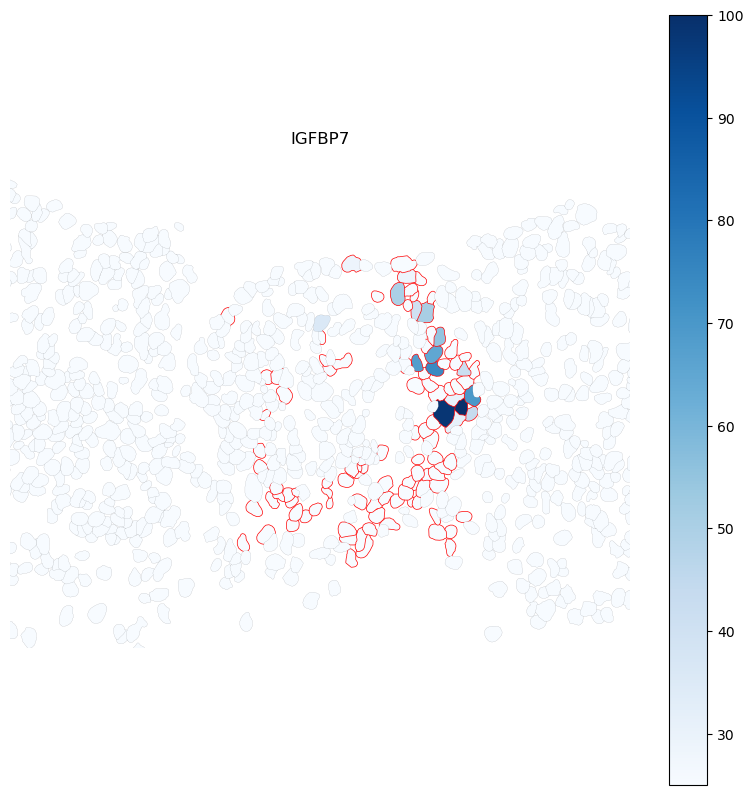

In [31]:
clusters_of_interest = [311,372]
clusters_of_interest = [448,325]
clusters_of_interest = [448]
# cluster_colors= ['gray','lightgray']
# cluster_colors= ['r','b']
cmaps = ['Blues','Reds']
# cmaps = ['Reds','Blues']

gene_name = 'IGFBP7'

fig, ax = plt.subplots(figsize=(10, 10))
for c,cluster in enumerate(clusters_of_interest):
    print(cluster)
    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster]

    merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')
    
    print(merged_gdf.shape)
    merged_gdf.plot(column=gene_name, cmap='Blues', legend=True, ax=ax,vmin=25,vmax=100,edgecolor='r',linewidth=0.5)

this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')

# print(merged_gdf.shape)
merged_gdf.plot(column=gene_name, cmap='Blues', legend=False, ax=ax,vmin=25,vmax=100,edgecolor='k',linewidth=0.05)

# for gene in gene_list:

# this_gene_df = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['name']==gene_name]
    # this_gene_df = 
    
# plt.scatter(this_gene_df['x'],this_gene_df['y'],marker='.',s=0.2,color=gene_colors[gene_list.index(gene)],alpha=0.7)
    
    # plt.axis('off')

ax.set_title(gene_name)
ax.set_aspect('equal')


# plt.xlim(0,20000)
# plt.ylim(20000,38000)

# plt.xlim(42000,52000)
# plt.ylim(40000,45000)

plt.xlim(42000,47000)
plt.ylim(40500,44500)

ax.axis('off')

plt.savefig(f'plots/{roi_name}_{gene_name}_expression_bc_cluster{clusters_of_interest}.png',bbox_inches='tight',dpi=300)

In [24]:
clusters_of_interest = [448]
adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id']


object_id
60643    60643
60780    60780
60850    60850
60761    60761
60937    60937
         ...  
64268    64268
64527    64527
64561    64561
64702    64702
64709    64709
Name: cell_id, Length: 108, dtype: object

In [32]:
sg_obj.get_cell_gene_table_df()



No filtering available or applied.


object_id  AKT1  AXL  BGN  BIRC3  BIRC5  BMP2  BMP4  CALD1  CAPG  ...  \
0            1.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    1.0   0.0  ...   
1            2.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    0.0   1.0  ...   
2            3.0   0.0  0.0  0.0    0.0    1.0   0.0   0.0    3.0   3.0  ...   
3            4.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    0.0   0.0  ...   
4            7.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    0.0   1.0  ...   
...          ...   ...  ...  ...    ...    ...   ...   ...    ...   ...  ...   
67197    67193.0   2.0  0.0  6.0    0.0    1.0   0.0   0.0    9.0  14.0  ...   
67198    67199.0   0.0  0.0  0.0    0.0    1.0   0.0   0.0    7.0  10.0  ...   
67199    67200.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    1.0   5.0  ...   
67200    67201.0   0.0  0.0  0.0    0.0    0.0   0.0   0.0    2.0   1.0  ...   
67201    67202.0   0.0  0.0  1.0    0.0    0.0   0.0   0.0    0.0   1.0  ...   

       bc_087  bc_088  bc_089  bc_090  bc_091  bc_092  bc_093  bc_094  bc_095  \
0         0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
67197     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
67198     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
67199     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
67200     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
67201     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       bc_096  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
...       ...  
67197     0.0  
67198     0.0  
67199     0.0  
67200     0.0  
67201     0.0  

[67202 rows x 216 columns]

In [33]:
sg_obj.gdf['cell_id'] = sg_obj.gdf.index
sg_obj.gdf['object_id'] = sg_obj.gdf.index

In [49]:
df[df['cell_id'].isin(cluster_cells)]['IGFBP7'].values

array([  0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   3.,   1.,  44.,  31., 100.,  98.,
        30.,   0.,   6.,  70.,  20.,  19.,   1.,   6.,  19.,   8.,   3.,
        13.,  22.,   6.,  74.,  42.,   4.,   0.,  18.,  68.,   7.,  14.,
         4.,  65.,   3.,   9.,   0.,  55.,   3.,   0.,  51.,  40.,   3.,
        11.,   4.,   7.,  11.,  50.,  18.,  29.,  15.,  29.],
      dtype=float32)

In [34]:
clusters_of_interest = [448]
cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)

for cell_id in ['64561']:

    # print(cell_id,mapping_dict[cell_id],df[df['cell_id']==cell_id]['called_barcodes'].values[0])

    # print(df[df['cell_id']==cell_id]['area'].values[0])
    # print(adata_genes.obs.loc[cell_id]['total_counts']) 

    print(df[df['cell_id']==cell_id]['area'].values[0])

    region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=10,id_field='cell_id')

    gene_names = ['bc_037', 'bc_057', 'bc_062', 'bc_063', 'bc_076']



    # gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')
    # gene_names = list(np.unique(gene_names))
    # gene_names.append('IGFBP7')
    # gene_names.append('VEGFA')
    # gene_names.append('MITF')
    # gene_names = ['IGFBP7']

    print(np.unique(gene_names))

    # print(gene_names)

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    ax = tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,
                                   annotate=False,image_scale=60,label=f'in cluster {clusters_of_interest[0]}',
                                   focal_outline_color='r',other_outline_color='gray',
                                   interior_marker='.',
                                   exterior_marker='.',marker_size=2)

    plt.xlim(42000,47000)
    plt.ylim(40500,44500)
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

14818.19538408949
['bc_037' 'bc_057' 'bc_062' 'bc_063' 'bc_076']


AttributeError: 'Polygon' object has no attribute 'geometry'

In [58]:
clusters_of_interest = [448]
cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)

for cell_id in ['64561']:

    # print(cell_id,mapping_dict[cell_id],df[df['cell_id']==cell_id]['called_barcodes'].values[0])

    # print(df[df['cell_id']==cell_id]['area'].values[0])
    # print(adata_genes.obs.loc[cell_id]['total_counts']) 

    print(df[df['cell_id']==cell_id]['area'].values[0])

    region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=10,id_field='cell_id')

    gene_names = ['bc_037', 'bc_057', 'bc_062', 'bc_063', 'bc_076']



    gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')
    gene_names = list(np.unique(gene_names))
    gene_names.append('IGFBP7')
    gene_names.append('VEGFA')
    gene_names.append('MITF')
    # gene_names = 'IGFBP7'

    print(np.unique(gene_names))

    # print(gene_names)

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    ax = tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,
                                   annotate=False,image_scale=60,label=f'in cluster {clusters_of_interest[0]}',
                                   focal_outline_color='k',other_outline_color='gray',
                                   interior_marker='.',
                                   exterior_marker='.',marker_size=2)

    plt.xlim(42000,47000)
    plt.ylim(40500,44500)
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

cell_id  n_called_barcodes  \
object_id                              
60643       60643                  0   
60780       60780                  2   
60850       60850                  5   
60761       60761                  1   
60937       60937                  1   
...           ...                ...   
64268       64268                  2   
64527       64527                  2   
64561       64561                  7   
64702       64702                  0   
64709       64709                  6   

                                              barcode_names  \
object_id                                                     
60643                                                         
60780                                         bc_057-bc_062   
60850                    bc_037-bc_057-bc_062-bc_063-bc_076   
60761                                                bc_057   
60937                                                bc_057   
...                                                     ...   
64268                                         bc_062-bc_076   
64527                                         bc_057-bc_062   
64561      bc_037-bc_039-bc_057-bc_062-bc_063-bc_076-bc_084   
64702                                                         
64709             bc_039-bc_057-bc_062-bc_063-bc_076-bc_084   

                                             called_barcodes          area  \
object_id                                                                    
60643                                                     []  10061.694162   
60780                                       [bc_057, bc_062]   9059.835243   
60850               [bc_037, bc_057, bc_062, bc_063, bc_076]   9951.517852   
60761                                               [bc_057]  15366.110151   
60937                                               [bc_057]  12453.645101   
...                                                      ...           ...   
64268                                       [bc_062, bc_076]  17950.680944   
64527                                       [bc_057, bc_062]   8741.776343   
64561      [bc_037, bc_039, bc_057, bc_062, bc_063, bc_07...  14818.195384   
64702                                                     []  21495.941249   
64709       [bc_039, bc_057, bc_062, bc_063, bc_076, bc_084]  17245.118429   

               center_x      center_y  n_genes  bc_cluster  bc_cluster_n_bcs  \
object_id                                                                      
60643      44753.313803  41220.620699       16       448.0               5.0   
60780      45551.603503  41313.045913       27       448.0               5.0   
60850      43880.466729  41342.164395       32       448.0               5.0   
60761      44865.483967  41315.722276       26       448.0               5.0   
60937      44744.056752  41379.831104       23       448.0               5.0   
...                 ...           ...      ...         ...               ...   
64268      45129.167776  43354.453082       30       448.0               5.0   
64527      45300.189515  43474.098335       25       448.0               5.0   
64561      45203.094122  43497.001446       31       448.0               5.0   
64702      45170.228806  43594.178242       21       448.0               5.0   
64709      44758.371038  43594.733803       29       448.0               5.0   

                               bc_cluster_found_bcs  \
object_id                                             
60643      [bc_037, bc_057, bc_062, bc_063, bc_076]   
60780      [bc_037, bc_057, bc_062, bc_063, bc_076]   
60850      [bc_037, bc_057, bc_062, bc_063, bc_076]   
60761      [bc_037, bc_057, bc_062, bc_063, bc_076]   
60937      [bc_037, bc_057, bc_062, bc_063, bc_076]   
...                                             ...   
64268      [bc_037, bc_057, bc_062, bc_063, bc_076]   
64527      [bc_037, bc_057, bc_062, bc_063, bc_076]   
64561      [bc_037, bc_057, bc_062, bc_063, bc_076]   
64702   

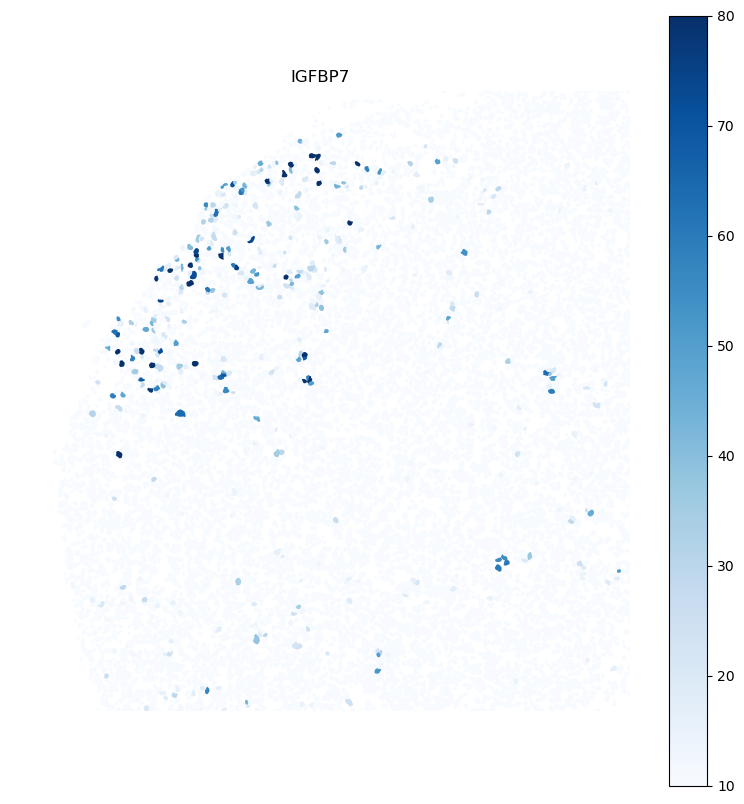

In [210]:
# this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf = sg_obj.gdf.merge(cell_gene_table_df, on='object_id', how='left')

# print(merged_gdf.shape)
merged_gdf.plot(column=gene_name, cmap='Blues', legend=True, ax=ax,vmin=10,vmax=80,edgecolor='None',linewidth=0.05)
ax.set_title(gene_name)
ax.set_aspect('equal')

plt.xlim(1000,16000)
plt.ylim(22000,37000)



ax.axis('off')
plt.savefig('plots/IGFBP7_zoomed.pdf')

In [202]:


triple_bc_clusters = adata_genes.obs[adata_genes.obs['bc_cluster_n_bcs'] >= 3]    

cs,counts = np.unique([int(x) for x in triple_bc_clusters['bc_cluster'].values],return_counts=True)

cs[np.argsort(counts)[::-1]]

array([ 311,  372,   91, 1214,   39, 1096,  512,  238, 1114,  644,   31,
        277, 1101,  256,  332,    8,  258,   71,   72,   78,   42,  161,
         92, 1394,   26,  100,  208,  448,  157,  412,  109,   97,  910,
        746,  617, 1020,  538,   55,  965,   28,  564,  176,  756,  195,
         16, 1534,  186,  753,  927,  356,   10, 3176,   49,  481,  155,
        846, 1510,  511,  431,  228,  250,   57, 1408,  396, 1080,  894,
       1254,  651,  684, 1590,  175, 1383,  335,  632, 1315,  863,  539,
        381,  622,   22,  204,  213,  338,  321, 1511, 1522,  344, 1190,
        196,  279,  331,   93,  527,  318,  339,  329,  325,  599,  247,
        300,  255, 1677,  888,  411,  795,  293,  652, 1692, 1442,  394,
        748,  818,   47, 1666,  620,  112,  567,   83,   41,  783,  605,
        222,  438,  371,  467,  454, 1401, 1072,  446, 1820,  981,  407,
       1228, 1148, 2616,  360, 1112,  319, 1404,  309,  232,  167,  340,
        525, 1646,  551, 1658,  127,  889, 1561,  8

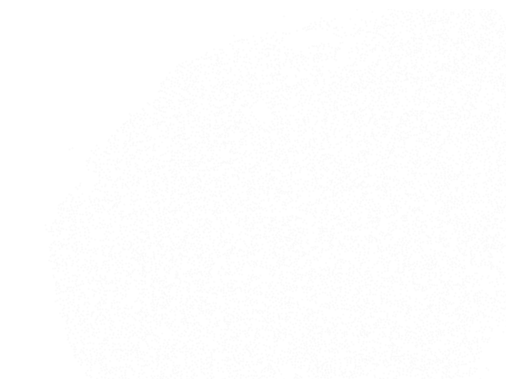

In [54]:
bc_colors = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=len(clusters_to_show))
bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(clusters_to_show)}

bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.02)  for bc in adata_genes.obs['bc_cluster'] ]

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
            c=bc_color_list,
            s=0.5)

plt.xlim(1000,16000)
plt.ylim(22000,37000)

plt.axis('off')
plt.savefig(f'plots/{roi_name}_bc_clusters_zoom372.pdf',bbox_inches='tight')

In [53]:
clusters_to_show = []

for clu,count in zip(cs[np.argsort(counts)[::-1]],counts[np.argsort(counts)[::-1]]):
    if count > 15:
        clusters_to_show.append(clu)
        print(clu,count,cluster_n_found_barcodes[clu],cluster_barcode_names[clu])

IndexError: index 3396 is out of bounds for axis 0 with size 966

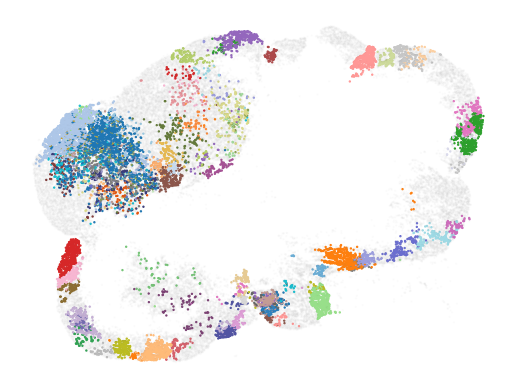

In [206]:
bc_colors = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=len(clusters_to_show))
bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(clusters_to_show)}

bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.02)  for bc in adata_genes.obs['bc_cluster'] ]

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
            c=bc_color_list,
            s=0.5)


plt.axis('off')
# plt.savefig(f'plots/{roi_name}_bc_clusters.pdf',bbox_inches='tight')

311
(1388, 222)
372
(1150, 222)
91
(415, 222)
1214
(389, 222)
39
(374, 222)
1096
(368, 222)
512
(366, 222)
238
(342, 222)
1114
(332, 222)
644
(236, 222)
31
(195, 222)
277
(187, 222)
1101
(185, 222)
256
(182, 222)
332
(177, 222)
8
(172, 222)
258
(163, 222)
71
(162, 222)
72
(161, 222)
78
(151, 222)
42
(146, 222)
161
(146, 222)
92
(138, 222)
1394
(136, 222)
26
(135, 222)
100
(124, 222)
208
(112, 222)
448
(108, 222)
157
(97, 222)
412
(93, 222)
109
(92, 222)
97
(85, 222)
910
(82, 222)
746
(79, 222)
617
(78, 222)
1020
(77, 222)
538
(76, 222)
55
(76, 222)
965
(76, 222)
28
(75, 222)
564
(69, 222)
176
(64, 222)
756
(64, 222)
195
(61, 222)
16
(58, 222)
1534
(57, 222)
186
(56, 222)
753
(53, 222)
927
(52, 222)
356
(50, 222)
10
(49, 222)
3176
(48, 222)
49
(47, 222)
481
(47, 222)
155
(44, 222)
846
(40, 222)
1510
(39, 222)
511
(38, 222)
431
(37, 222)
228
(36, 222)
250
(35, 222)
57
(34, 222)
1408
(31, 222)
396
(31, 222)
1080
(31, 222)
894
(31, 222)
1254
(31, 222)
651
(31, 222)
684
(31, 222)
1590
(29, 

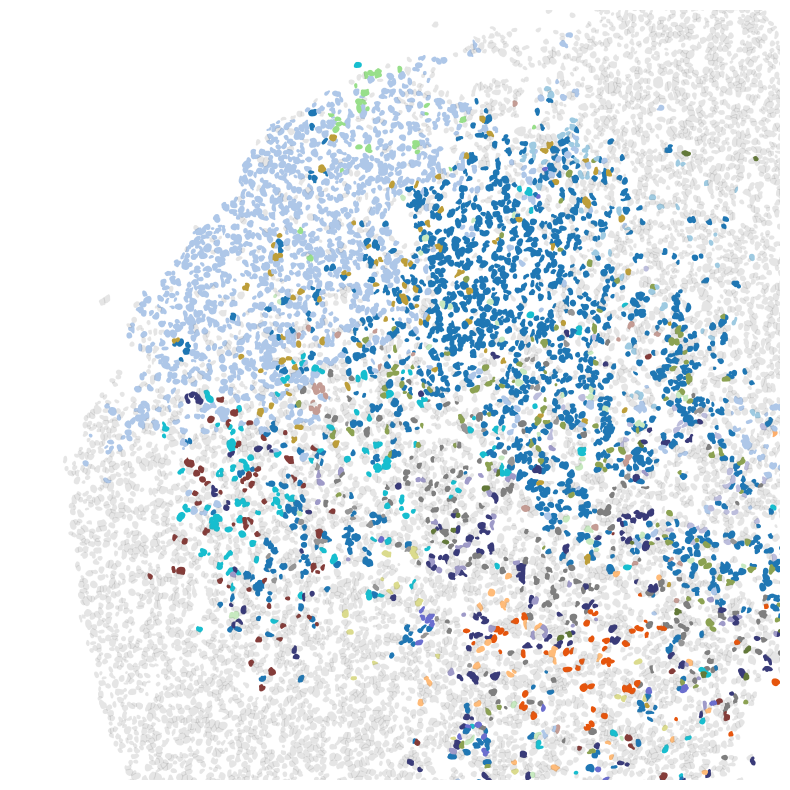

In [209]:
# clusters_of_interest = [311,372]
# clusters_of_interest = [448,325]
# clusters_of_interest = 
# cluster_colors= ['gray','lightgray']
# cluster_colors= ['r','b']
# cmaps = ['Blues','Reds']
# cmaps = ['Reds','Blues']

# gene_name = 'IGFBP7'

fig, ax = plt.subplots(figsize=(10, 10))
for c,cluster in enumerate(clusters_to_show):
    print(cluster)
    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster]

    merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')
    
    print(merged_gdf.shape)
    merged_gdf.plot(color=bc_color_dict[cluster],linewidth=0.5,ax=ax)

this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_to_show)]

merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')

# print(merged_gdf.shape)
merged_gdf.plot(color='gray',linewidth=0.05,ax=ax,alpha=0.2)

# for gene in gene_list:

# this_gene_df = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['name']==gene_name]
    # this_gene_df = 
    
# plt.scatter(this_gene_df['x'],this_gene_df['y'],marker='.',s=0.2,color=gene_colors[gene_list.index(gene)],alpha=0.7)
    
    # plt.axis('off')

# ax.set_title(gene_name)
ax.set_aspect('equal')


# plt.xlim(0,20000)
# plt.ylim(20000,38000)

# plt.xlim(42000,52000)
# plt.ylim(40000,45000)

# plt.xlim(42000,47000)
# plt.ylim(40500,44500)


plt.xlim(1000,16000)
plt.ylim(22000,37000)

ax.axis('off')

plt.savefig(f'plots/zoomed_clusters.png',bbox_inches='tight',dpi=300)

In [95]:
sg_obj.gdf['cluster'] = [obj_clusters[obj_id] if obj_id in obj_clusters else np.nan for obj_id in sg_obj.gdf.index]

In [96]:
sg_obj.

nucleus  \
object_id                                                      
1          POLYGON ((23727.000 1097.000, 23741.000 1098.0...   
2          POLYGON ((23811.000 1166.000, 23822.000 1166.0...   
3          POLYGON ((19383.000 1449.000, 19398.000 1451.0...   
4          POLYGON ((19107.000 1506.000, 19137.000 1507.0...   
7          POLYGON ((15238.000 1549.000, 15252.000 1549.0...   
...                                                      ...   
67193      POLYGON ((37771.000 46466.000, 37777.000 46470...   
67199      POLYGON ((38215.000 46546.000, 38237.000 46547...   
67200      POLYGON ((38366.000 46565.000, 38403.000 46566...   
67201      POLYGON ((38105.000 46579.000, 38137.000 46586...   
67202      POLYGON ((38499.000 46598.000, 38524.000 46598...   

                                             nucleus_dilated  \
object_id                                                      
1          POLYGON ((23723.193 1087.753, 23706.193 1094.7...   
2          POLYGON ((23807.286 1156.715, 23797.286 1160.7...   
3          POLYGON ((19378.528 1440.056, 19352.528 1453.0...   
4          POLYGON ((19091.029 1530.598, 19090.693 1531.3...   
7          POLYGON ((15236.760 1539.077, 15220.760 1541.0...   
...                                                      ...   
67193      POLYGON ((37765.537 46457.624, 37742.537 46472...   
67199      POLYGON ((38212.441 46536.333, 38179.699 46545...   
67200      POLYGON ((38364.157 46555.171, 38332.157 46561...   
67201      POLYGON ((38099.855 46570.425, 38096.394 46572...   
67202      POLYGON ((38496.253 46588.385, 38490.858 46589...   

                      nucleus_centroid      center_x      center_y  \
object_id                                                            
1           POINT (23747.880 1155.889)  23747.879606   1155.889230   
2           POINT (23806.278 1229.866)  23806.277927   1229.866352   
3           POINT (19365.232 1485.264)  19365.232060   1485.264038   
4           POINT (19129.721 1524.719)  19129.720568   1524.718822   
7           POINT (15196.783 1575.083)  15196.782900   1575.083015   
...                                ...           ...           ...   
67193      POINT (37783.462 46544.912)  37783.462010  46544.912100   
67199      POINT (38208.404 46576.996)  38208.404034  46576.996025   
67200      POINT (38384.677 46598.134)  38384.676549  46598.133528   
67201      POINT (38113.042 46613.436)  38113.042241  46613.435928   
67202      POINT (38503.604 46624.955)  38503.603601  46624.954506   

                   area cell_id object_id  
object_id                                  
1          12083.909039       1         1  
2          12327.850827       2         2  
3           6440.407723       3         3  
4           4279.403177       4         4  
7           5458.813969       7         7  
...                 ...     ...       ...  
67193      13678.319345   67193     67193  
67199       9246.990769   67199     67199  
67200      10661.078562   67200     67200  
67201       8041.815355   67201     67201  
67202       6580.028514   67202     67202  

[67202 rows x 8 columns]

In [60]:
clusters_of_interest = [372]
cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)

In [61]:
cluster_cells 

['28919',
 '30179',
 '30402',
 '34164',
 '34814',
 '35144',
 '36267',
 '36368',
 '36601',
 '37110',
 '37259',
 '37233',
 '37279',
 '37498',
 '37880',
 '38095',
 '38322',
 '38881',
 '39038',
 '39241',
 '39272',
 '39390',
 '39360',
 '39422',
 '39337',
 '39505',
 '39578',
 '39545',
 '39739',
 '39676',
 '39812',
 '39854',
 '39876',
 '39907',
 '39912',
 '39905',
 '39897',
 '39981',
 '39867',
 '39947',
 '39971',
 '40045',
 '40127',
 '40157',
 '40161',
 '40112',
 '40084',
 '40209',
 '40206',
 '40248',
 '40309',
 '40236',
 '40298',
 '40198',
 '40249',
 '40303',
 '40346',
 '40416',
 '40356',
 '40399',
 '40411',
 '40455',
 '40456',
 '40437',
 '40391',
 '40364',
 '40339',
 '40375',
 '40376',
 '40491',
 '40529',
 '40706',
 '40608',
 '40676',
 '40563',
 '40555',
 '40711',
 '40658',
 '40691',
 '40558',
 '40659',
 '40699',
 '40682',
 '40626',
 '40652',
 '40778',
 '40780',
 '40824',
 '40802',
 '40742',
 '40831',
 '40833',
 '40868',
 '40853',
 '40885',
 '40781',
 '40972',
 '41080',
 '41130',
 '40919',


13326.572341966861
['bc_001' 'bc_004' 'bc_007' 'bc_022' 'bc_024' 'bc_025' 'bc_028' 'bc_029'
 'bc_031' 'bc_037' 'bc_041' 'bc_048' 'bc_059' 'bc_060' 'bc_064' 'bc_067'
 'bc_068' 'bc_074' 'bc_076' 'bc_077' 'bc_080' 'bc_085' 'bc_087' 'bc_089'
 'bc_092' 'bc_093' 'bc_095']
['37880']


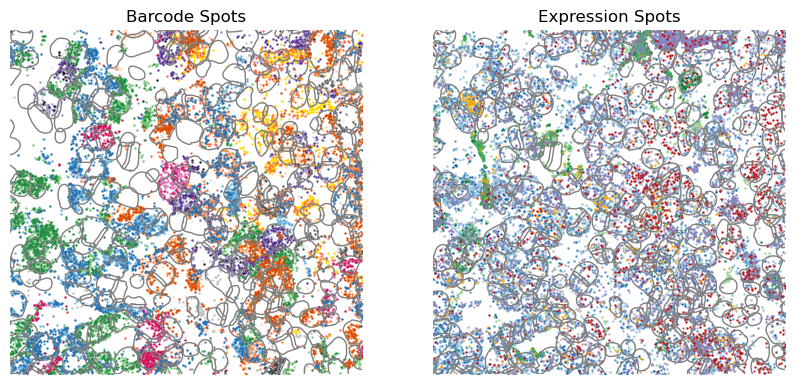

In [150]:
clusters_of_interest = [372]
cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)
cluster_cells = ['37880']

for cell_id in ['37880']:

    # print(cell_id,mapping_dict[cell_id],df[df['cell_id']==cell_id]['called_barcodes'].values[0])

    # print(df[df['cell_id']==cell_id]['area'].values[0])
    # print(adata_genes.obs.loc[cell_id]['total_counts']) 

    print(df[df['cell_id']==cell_id]['area'].values[0])

    region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=15,id_field='cell_id')

    # gene_names = ['bc_037', 'bc_057', 'bc_062', 'bc_063', 'bc_076']



    gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')
    gene_names = list(np.unique(gene_names))
    # gene_names.append('IGFBP7')
    # gene_names.append('VEGFA')
    # gene_names.append('MITF')
    # gene_names = 'IGFBP7'
    # gene_names = ['IGFBP7','VEGFA','MITF']

    color_map = {'bc_025':sns.color_palette('Blues',3)[1],
 'bc_092':sns.color_palette('Blues',3)[2],

 'bc_074':sns.color_palette('Greens',3)[1],
 'bc_093':sns.color_palette('Greens',3)[2],

 'bc_067':sns.color_palette('Oranges',3)[0],
 'bc_077':sns.color_palette('Oranges',3)[1],
 'bc_087':sns.color_palette('Oranges',3)[2],

 'bc_060':sns.color_palette('Reds',3)[1],
#  'bc_092':sns.color_palette('Reds',3)[2],

 'bc_048':'gold',

 'bc_028':sns.color_palette('PuRd',3)[1],
 'bc_095':sns.color_palette('PuRd',3)[2],

 'bc_029':sns.color_palette('Purples',5)[0],
'bc_059':sns.color_palette('Purples',5)[1],
'bc_064':sns.color_palette('Purples',5)[2], 
'bc_068':sns.color_palette('Purples',5)[3],
'bc_085':sns.color_palette('Purples',5)[4],
 }
    counter = 0
    for gene in gene_names:
        if gene not in color_map.keys():
            color_map[gene] = sns.color_palette('Greys',10)[counter%10]
            counter+=1

    print(np.unique(gene_names))
    print(cluster_cells)

    plt.figure(figsize=(10,10))

    ax = plt.subplot(1,2,1)

    # print(gene_names)

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,
                                   annotate=False,image_scale=15,label=f'in cluster {clusters_of_interest[0]}',
                                   focal_outline_color='gray',other_outline_color='gray',
                                   interior_marker='.',color_map=color_map,
                                   exterior_marker='.',marker_size=2,ax=ax)
    plt.title('Barcode Spots')
    

    plt.axis('off')

    ax = plt.subplot(1,2,2)
    gene_names = ['IGFBP7','VEGFA','MITF','COL1A1','MLANA','IFIT2','MMP1','MMP11','NANOG','BMP2']
    color_map = {'VEGFA':sns.color_palette('Reds',3)[2],
                 'MITF':sns.color_palette('Blues',3)[1],
                 'IGFBP7':sns.color_palette('PuRd',3)[2],
                 'COL1A1':'g',
                 'IFIT2':'gold',
                 'MMP1':'orange',
                 'MMP11':'orange',
                 'NANOG':'k',
                 'BMP2':'k',
                 'MLANA':sns.color_palette('Blues',3)[2]}
    
    cluster_genes = {0:['MITF','MLANA','CAPG'],
                     1:['VEGFA','NRG1','BIRC3'],
                     2:['COL1A1','COL5A2','BGN'],
                     3:['MMP11','BMP2','ROR2'],
                     4:['NANOG','TYR','ERBB3'],
                     5: ['ITGA8','TYR','SLC7A8'],
                     6: ['OASL','IFIT2','RIGI'],
                     7: ['MMP1','SERPINE1','NT5E']}
    
    cluster_colors = {0:'Blues',
                      1:'Reds',
                      2:'Greens',
                      3:'Oranges',
                      4:'Greys',
                      5:'Purples',
                      6:'PuRd',
                      7:'Purples'}
    
    gene_names = [gene  for gene_list in cluster_genes.values() for gene in gene_list]
    gene_names.append('IGFBP7')

    color_map = {gene:sns.color_palette(cluster_colors[cluster],4)[3-g]  for cluster,gene_list in cluster_genes.items() for g,gene in enumerate(gene_list)}
    
    color_map['IGFBP7'] = 'orange'

    tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,
                                   annotate=False,image_scale=15,label=f'in cluster {clusters_of_interest[0]}',
                                   focal_outline_color='gray',other_outline_color='gray',
                                   interior_marker='.',color_map=color_map,
                                   exterior_marker='.',marker_size=2,ax=ax)
    
    plt.title('Expression Spots')

    # plt.xlim(42000,47000)
    # plt.ylim(40500,44500)

    plt.axis('off')

    plt.savefig(f'plots/{cell_id}_region_barcode+expression.pdf',bbox_inches='tight')
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

13326.572341966861
['bc_001' 'bc_004' 'bc_007' 'bc_022' 'bc_024' 'bc_025' 'bc_028' 'bc_029'
 'bc_031' 'bc_037' 'bc_041' 'bc_048' 'bc_059' 'bc_060' 'bc_064' 'bc_067'
 'bc_068' 'bc_074' 'bc_076' 'bc_077' 'bc_080' 'bc_085' 'bc_087' 'bc_089'
 'bc_092' 'bc_093' 'bc_095']
['37880']


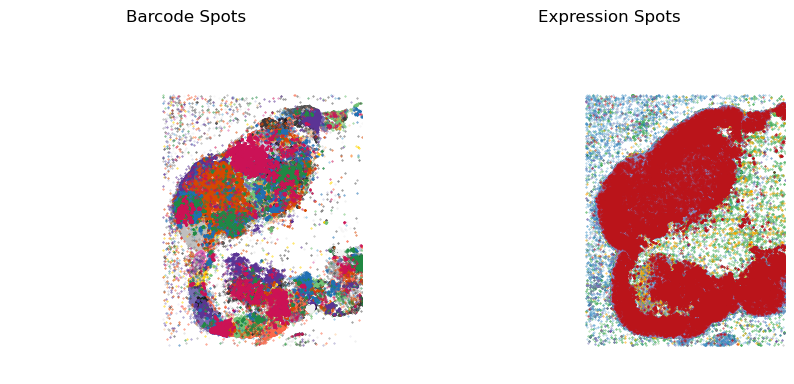

In [153]:
clusters_of_interest = [372]
cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)
cluster_cells = ['37880']

for cell_id in ['37880']:

    # print(cell_id,mapping_dict[cell_id],df[df['cell_id']==cell_id]['called_barcodes'].values[0])

    # print(df[df['cell_id']==cell_id]['area'].values[0])
    # print(adata_genes.obs.loc[cell_id]['total_counts']) 

    print(df[df['cell_id']==cell_id]['area'].values[0])

    region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=15,id_field='cell_id')

    # gene_names = ['bc_037', 'bc_057', 'bc_062', 'bc_063', 'bc_076']



    gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')
    gene_names = list(np.unique(gene_names))
    # gene_names.append('IGFBP7')
    # gene_names.append('VEGFA')
    # gene_names.append('MITF')
    # gene_names = 'IGFBP7'
    # gene_names = ['IGFBP7','VEGFA','MITF']

    color_map = {'bc_025':sns.color_palette('Blues',3)[1],
 'bc_092':sns.color_palette('Blues',3)[2],

 'bc_074':sns.color_palette('Greens',3)[1],
 'bc_093':sns.color_palette('Greens',3)[2],

 'bc_067':sns.color_palette('Oranges',3)[0],
 'bc_077':sns.color_palette('Oranges',3)[1],
 'bc_087':sns.color_palette('Oranges',3)[2],

 'bc_060':sns.color_palette('Reds',3)[1],
#  'bc_092':sns.color_palette('Reds',3)[2],

 'bc_048':'gold',

 'bc_028':sns.color_palette('PuRd',3)[1],
 'bc_095':sns.color_palette('PuRd',3)[2],

 'bc_029':sns.color_palette('Purples',5)[0],
'bc_059':sns.color_palette('Purples',5)[1],
'bc_064':sns.color_palette('Purples',5)[2], 
'bc_068':sns.color_palette('Purples',5)[3],
'bc_085':sns.color_palette('Purples',5)[4],
 }
    counter = 0
    for gene in gene_names:
        if gene not in color_map.keys():
            color_map[gene] = sns.color_palette('Greys',10)[counter%10]
            counter+=1

    print(np.unique(gene_names))
    print(cluster_cells)

    plt.figure(figsize=(10,10))

    ax = plt.subplot(1,2,1)

    # print(gene_names)

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,
                                   annotate=False,image_scale=500,label=f'in cluster {clusters_of_interest[0]}',
                                   focal_outline_color='gray',other_outline_color='gray',
                                   interior_marker='.',color_map=color_map,
                                   exterior_marker='.',marker_size=0.5,ax=ax,lw=0)
    plt.title('Barcode Spots')
    

    plt.axis('off')

    ax = plt.subplot(1,2,2)
    gene_names = ['IGFBP7','VEGFA','MITF','COL1A1','MLANA','IFIT2','MMP1','MMP11','NANOG','BMP2']
    color_map = {'VEGFA':sns.color_palette('Reds',3)[2],
                 'MITF':sns.color_palette('Blues',3)[1],
                 'IGFBP7':sns.color_palette('PuRd',3)[2],
                 'COL1A1':'g',
                 'IFIT2':'gold',
                 'MMP1':'orange',
                 'MMP11':'orange',
                 'NANOG':'k',
                 'BMP2':'k',
                 'MLANA':sns.color_palette('Blues',3)[2]}
    
    cluster_genes = {0:['MITF','MLANA','CAPG'],
                     1:['VEGFA','NRG1','BIRC3'],
                     2:['COL1A1','COL5A2','BGN'],
                     3:['MMP11','BMP2','ROR2'],
                     4:['NANOG','TYR','ERBB3'],
                     5: ['ITGA8','TYR','SLC7A8'],
                     6: ['OASL','IFIT2','RIGI'],
                     7: ['MMP1','SERPINE1','NT5E']}
    
    cluster_colors = {0:'Blues',
                      1:'Reds',
                      2:'Greens',
                      3:'Oranges',
                      4:'Greys',
                      5:'Purples',
                      6:'PuRd',
                      7:'Purples'}
    
    gene_names = [gene  for gene_list in cluster_genes.values() for gene in gene_list]
    gene_names.append('IGFBP7')

    color_map = {gene:sns.color_palette(cluster_colors[cluster],4)[3-g]  for cluster,gene_list in cluster_genes.items() for g,gene in enumerate(gene_list)}
    
    color_map['IGFBP7'] = 'orange'

    tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,
                                   annotate=False,image_scale=500,label=f'in cluster {clusters_of_interest[0]}',
                                   focal_outline_color='gray',other_outline_color='gray',
                                   interior_marker='.',color_map=color_map,
                                   exterior_marker='.',marker_size=0.5,ax=ax,lw=0)
    
    plt.title('Expression Spots')

    # plt.xlim(42000,47000)
    # plt.ylim(40500,44500)

    plt.axis('off')

    plt.savefig(f'plots/{cell_id}_region_barcode+expression_big500.pdf',bbox_inches='tight')
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

(-648.8675447522292, 59258.76371243313, -771.1445560851262, 48869.84452242345)

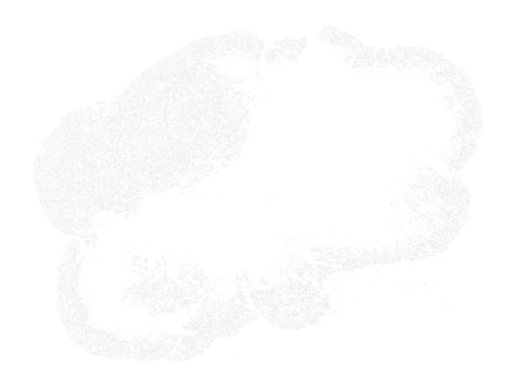

In [154]:
bc_colors = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=len(clusters_to_show))
bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(clusters_to_show)}

bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.02)  for bc in adata_genes.obs['bc_cluster'] ]

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='.',
            c=bc_color_list,
            s=0.5)


plt.axis('off')
# plt.savefig(f'plots/{roi_name}_bc_clusters.pdf',bbox_inches='tight')

In [158]:
barcodes

name   refid      x      y                     geometry
4724830  bc_001  bc_001  26434     95     POINT (26434.000 95.000)
4724831  bc_001  bc_001  58827    214    POINT (58827.000 214.000)
4724832  bc_001  bc_001  18112    444    POINT (18112.000 444.000)
4724833  bc_001  bc_001  51441    410    POINT (51441.000 410.000)
4724834  bc_001  bc_001  57373    349    POINT (57373.000 349.000)
...         ...     ...    ...    ...                          ...
6744064  bc_096  bc_096  46504  43433  POINT (46504.000 43433.000)
6744065  bc_096  bc_096  44703  43537  POINT (44703.000 43537.000)
6744066  bc_096  bc_096  34522  44556  POINT (34522.000 44556.000)
6744067  bc_096  bc_096  35333  45249  POINT (35333.000 45249.000)
6744068  bc_096  bc_096  48198  47134  POINT (48198.000 47134.000)

[2019239 rows x 5 columns]

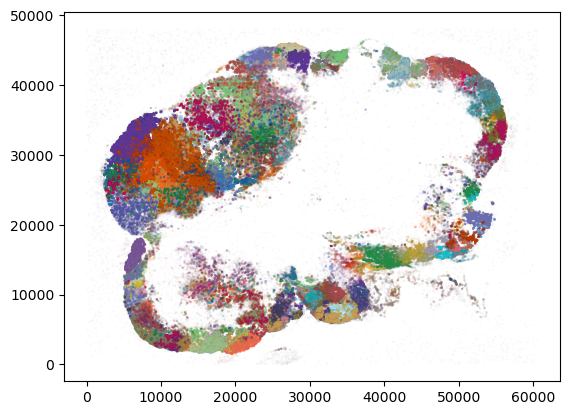

In [171]:
barcode_points = sg_obj.points_gdf[sg_obj.points_gdf['name'].str.contains('bc_')]

color_map = {'bc_025':sns.color_palette('Blues',3)[1],
 'bc_092':sns.color_palette('Blues',3)[2],

 'bc_074':sns.color_palette('Greens',3)[1],
 'bc_093':sns.color_palette('Greens',3)[2],

 'bc_067':sns.color_palette('Oranges',3)[0],
 'bc_077':sns.color_palette('Oranges',3)[1],
 'bc_087':sns.color_palette('Oranges',3)[2],

 'bc_060':sns.color_palette('Reds',3)[1],
#  'bc_092':sns.color_palette('Reds',3)[2],

 'bc_048':'gold',

 'bc_028':sns.color_palette('PuRd',3)[1],
 'bc_095':sns.color_palette('PuRd',3)[2],

 'bc_029':sns.color_palette('Purples',5)[0],
'bc_059':sns.color_palette('Purples',5)[1],
'bc_064':sns.color_palette('Purples',5)[2], 
'bc_068':sns.color_palette('Purples',5)[3],
'bc_085':sns.color_palette('Purples',5)[4],
 }


big_c_list = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=97)
for n,name in enumerate(np.unique(barcode_points['name'].values)):
    if name not in color_map.keys():
        color_map[name] = big_c_list[n]

bc_color_list = [colors.to_rgba(color_map[bc],alpha=0.1) for bc in barcode_points ['name'] ]
        
plt.scatter(barcode_points['x'],barcode_points['y'],marker='.',
            c=bc_color_list,
            s=0.1)

plt.savefig('plots/ROI2_whole_tumor_barcodes.pdf',bbox_inches='tight')
plt.savefig('plots/ROI2_whole_tumor_barcodes.png',bbox_inches='tight',dpi=300)

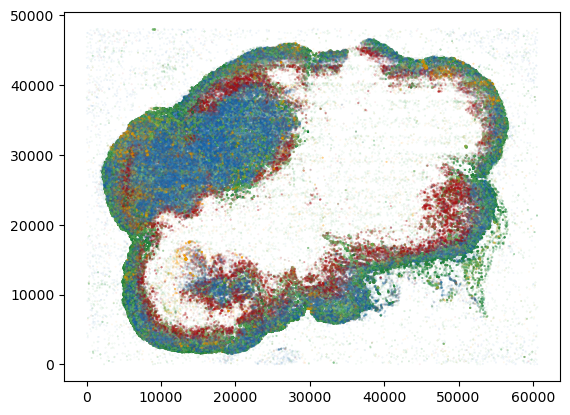

In [175]:
expression_points = sg_obj.points_gdf[~sg_obj.points_gdf['name'].str.contains('bc_')]

cluster_genes = {
                    # 0:['MITF','MLANA','CAPG'],
                    0:['MITF','MLANA'],
                    # 1:['VEGFA','NRG1','BIRC3'],
                    1:['VEGFA'],
                    2:['COL1A1','COL5A2','BGN'],
                    #  3:['MMP11','BMP2','ROR2'],
                    #  4:['NANOG','TYR','ERBB3'],
                    #  5: ['ITGA8','TYR','SLC7A8'],
                    #  6: ['OASL','IFIT2','RIGI'],
                    #  7: ['MMP1','SERPINE1','NT5E']
                     }
    
cluster_colors = {0:'Blues',
                      1:'Reds',
                      2:'Greens',
                      3:'Oranges',
                      4:'Greys',
                      5:'Purples',
                      6:'PuRd',
                      7:'Purples'}
    
gene_names = [gene  for gene_list in cluster_genes.values() for gene in gene_list]
gene_names.append('IGFBP7')


color_map = {gene:sns.color_palette(cluster_colors[cluster],4)[3-g]  for cluster,gene_list in cluster_genes.items() for g,gene in enumerate(gene_list)}

color_map['IGFBP7'] = 'orange'


expression_points = expression_points[expression_points['name'].isin(gene_names)]

expression_points_shuffled = expression_points.sample(frac=1,axis=0)


# big_c_list = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=97)
# for n,name in enumerate(np.unique(barcode_points['name'].values)):
#     if name not in color_map.keys():
#         color_map[name] = big_c_list[n]

expression_color_list = [colors.to_rgba(color_map[gene],alpha=0.1) for gene in expression_points_shuffled['name'] ]
        
plt.scatter(expression_points_shuffled['x'],expression_points_shuffled['y'],marker='o',
            c=expression_color_list,
            s=0.1)

plt.savefig('plots/ROI2_whole_tumor_expression.pdf',bbox_inches='tight')
plt.savefig('plots/ROI2_whole_tumor_expression.png',bbox_inches='tight',dpi=300)

In [166]:
sc. 

name            refid      x      y                     geometry
2523335       MITF  ENSG00000187098  28148   6872   POINT (28148.000 6872.000)
11096051  SERPINE1  ENSG00000106366  22644  37588  POINT (22644.000 37588.000)
7645656       CAPG  ENSG00000042493  19655  29245  POINT (19655.000 29245.000)
16516687    COL5A2  ENSG00000204262  54225  20054  POINT (54225.000 20054.000)
2508136       MITF  ENSG00000187098  20605   2956   POINT (20605.000 2956.000)
...            ...              ...    ...    ...                          ...
7794229       CAPG  ENSG00000042493  14825  34349  POINT (14825.000 34349.000)
7333329       CAPG  ENSG00000042493  16507   8017   POINT (16507.000 8017.000)
7776770       CAPG  ENSG00000042493  55346  33674  POINT (55346.000 33674.000)
3357591      VEGFA  ENSG00000112715   7779  16134   POINT (7779.000 16134.000)
2163667      ERBB3  ENSG00000065361  20302  30025  POINT (20302.000 30025.000)

[2541627 rows x 5 columns]

In [107]:
clus,counts = np.unique([x for x in adata_genes.obs[adata_genes.obs['cell_id'].isin(region['cell_id'].values)]['bc_cluster_bc_names'].values if type(x) == str],return_counts=True)
print(clus[np.argsort(counts)[::-1]])
print(counts[np.argsort(counts)[::-1]])

['bc_025-bc_092' 'bc_074-bc_093' 'bc_067-bc_077-bc_087'
 'bc_060-bc_077-bc_092' 'bc_048-bc_060' 'bc_028-bc_095'
 'bc_029-bc_059-bc_064-bc_068-bc_085' 'bc_004-bc_041-bc_077'
 'bc_001-bc_029-bc_031-bc_087' 'bc_077-bc_092'
 'bc_025-bc_074-bc_092-bc_093'
 'bc_029-bc_059-bc_064-bc_074-bc_080-bc_085-bc_093'
 'bc_060-bc_067-bc_077-bc_087-bc_092' 'bc_022'
 'bc_029-bc_059-bc_064-bc_068-bc_074-bc_080-bc_085-bc_093' '' 'bc_060'
 'bc_074-bc_087' 'bc_025-bc_048-bc_060-bc_092' 'bc_048-bc_060-bc_092'
 'bc_067-bc_074-bc_077-bc_085-bc_087-bc_093' 'bc_028'
 'bc_028-bc_074-bc_093-bc_095' 'bc_077' 'bc_067' 'bc_064-bc_085'
 'bc_060-bc_077-bc_085-bc_092' 'bc_085'
 'bc_004-bc_029-bc_041-bc_059-bc_064-bc_085'
 'bc_004-bc_025-bc_041-bc_067-bc_077-bc_087' 'bc_045-bc_092'
 'bc_007-bc_060-bc_077-bc_092' 'bc_004-bc_041-bc_060-bc_092' 'bc_004'
 'bc_001-bc_031-bc_067-bc_087' 'bc_080-bc_085'
 'bc_001-bc_028-bc_029-bc_031-bc_087-bc_095' 'bc_004-bc_041-bc_087'
 'bc_007-bc_024-bc_060-bc_077-bc_092' 'bc_067-bc_087' 'bc_0

In [108]:
{'bc_025':sns.color_palette('Blues',3)[1],
 'bc_092':sns.color_palette('Blues',3)[2],

 'bc_074':sns.color_palette('Greens',3)[1],
 'bc_093':sns.color_palette('Greens',3)[2],

 'bc_067':sns.color_palette('Oranges',3)[0],
 'bc_077':sns.color_palette('Oranges',3)[1],
 'bc_087':sns.color_palette('Oranges',3)[2],

 'bc_060':sns.color_palette('Reds',3)[1],
 'bc_092':sns.color_palette('Reds',3)[2],

 'bc_048':sns.color_palette('Purples',3)[1],

 'bc_028':sns.color_palette('PuRd',3)[1],
 'bc_095':sns.color_palette('PuRd',3)[2]
 }

SyntaxError: invalid syntax (702438291.py, line 1)

In [952]:
clusters_of_interest = [372]
cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)

df[df['cell_id'].isin(cluster_cells)& (df['IGFBP7'] > cutoff)]['cell_id']

object_id
37880    37880
40364    40364
40555    40555
40558    40558
40802    40802
         ...  
51210    51210
51237    51237
51370    51370
51485    51485
52303    52303
Name: cell_id, Length: 115, dtype: object

In [953]:
df[df['cell_id']=='37880'][['bc_029', 'bc_059', 'bc_064', 'bc_068', 'bc_085']]

bc_029  bc_059  bc_064  bc_068  bc_085
object_id                                        
37880        16.0    25.0    16.0    11.0    38.0

In [954]:
['bc_029', 'bc_059', 'bc_064', 'bc_068', 'bc_085']

['bc_029', 'bc_059', 'bc_064', 'bc_068', 'bc_085']

In [955]:
sc.metrics.morans_i(adata_genes,adata_genes.obs['IGFBP7'].values,spatial_key='spatial')

KeyError: 'IGFBP7'

In [956]:
adata_genes

AnnData object with n_obs × n_vars = 49625 × 119
    obs: 'cell_id', 'n_called_barcodes', 'barcode_names', 'called_barcodes', 'area', 'center_x', 'center_y', 'n_genes', 'bc_cluster', 'bc_cluster_n_bcs', 'bc_cluster_found_bcs', 'bc_cluster_bc_names'
    var: 'n_cells'

ArrayView(416893)

In [957]:
adata_genes.obsm

AxisArrays with keys: 

In [932]:
adata_genes

AnnData object with n_obs × n_vars = 49625 × 119
    obs: 'cell_id', 'n_called_barcodes', 'barcode_names', 'called_barcodes', 'area', 'center_x', 'center_y', 'n_genes', 'bc_cluster', 'bc_cluster_n_bcs', 'bc_cluster_found_bcs', 'bc_cluster_bc_names'
    var: 'n_cells'

In order to determine whether there are genes that have intrinsic patterns of expression by clone, we are going to calculate average expression per clone, 

In [887]:
confident_clusters = adata_genes[(~np.isnan(adata_genes.obs['bc_cluster'])) & (adata_genes.obs['bc_cluster_n_bcs'] > 2) ]

clus,clus_counts = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)

clus_enough_cells = []

for clu,count in zip(clus,clus_counts):
    if count >= 25:
        clus_enough_cells.append(clu)

    print(clu,count)

confident_clusters = confident_clusters[confident_clusters.obs['bc_cluster'].isin(clus_enough_cells)]

# confident_clusters = adata_genes.obs.groupby('bc_cluster')
# confident_clusters = confident_clusters.filter(lambda x: len(x) > 5)

7.0 9
8.0 172
9.0 4
10.0 49
11.0 2
15.0 2
16.0 58
21.0 2
22.0 23
24.0 7
25.0 8
26.0 135
28.0 75
31.0 195
36.0 2
38.0 5
39.0 374
41.0 13
42.0 146
43.0 6
44.0 4
45.0 2
46.0 6
47.0 14
49.0 47
52.0 7
53.0 3
55.0 76
56.0 6
57.0 34
60.0 2
64.0 2
65.0 8
69.0 3
71.0 162
72.0 161
75.0 6
76.0 2
77.0 5
78.0 151
83.0 13
90.0 7
91.0 415
92.0 138
93.0 19
95.0 2
97.0 85
100.0 124
104.0 4
109.0 92
112.0 14
113.0 2
114.0 2
122.0 4
123.0 6
127.0 9
130.0 4
134.0 3
137.0 7
143.0 3
148.0 2
150.0 3
153.0 4
155.0 44
156.0 6
157.0 97
161.0 146
167.0 10
172.0 8
173.0 5
175.0 28
176.0 64
181.0 4
182.0 2
186.0 56
195.0 61
196.0 20
201.0 3
204.0 22
205.0 4
208.0 112
209.0 6
213.0 22
216.0 2
218.0 8
222.0 12
225.0 2
226.0 5
228.0 36
229.0 2
230.0 2
232.0 10
238.0 342
241.0 4
245.0 2
247.0 17
250.0 35
255.0 16
256.0 182
258.0 163
259.0 8
265.0 6
267.0 2
273.0 4
274.0 2
277.0 187
279.0 20
281.0 4
288.0 2
289.0 6
290.0 2
293.0 16
294.0 3
300.0 17
302.0 2
305.0 4
307.0 2
309.0 10
311.0 1388
314.0 2
315.0 7
318.0 19
31

In [888]:
confident_clusters

View of AnnData object with n_obs × n_vars = 10606 × 119
    obs: 'cell_id', 'n_called_barcodes', 'barcode_names', 'called_barcodes', 'area', 'center_x', 'center_y', 'n_genes', 'bc_cluster', 'bc_cluster_n_bcs', 'bc_cluster_found_bcs', 'bc_cluster_bc_names'
    var: 'n_cells'

In [1024]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64)).tolist()

    # print(out)
    return out

def grouped_obs_sum_squares(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(np.square(X).mean(axis=0, dtype=np.float64)).tolist()

    # print(out)
    return out

def grouped_obs_fraction(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(np.count_nonzero(X,axis=0)/X.shape[0]).tolist()

    # print(out)
    return out

def grouped_obs_fraction_quantile(adata, group_key,q=0.9, layer=None, gene_symbols=None):
# def grouped_obs_fraction_quantile(adata, group_key,q=0.5, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(np.sum(X>=np.quantile(getX(adata),q=q,axis=0),axis=0)/X.shape[0]).tolist()

    # print(out)
    return out

def grouped_obs_median(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(np.median(X,axis=0)).tolist()

    # print(out)
    return out

In [992]:
grouped = confident_clusters.obs.groupby('bc_cluster')
out = pd.DataFrame(
        np.zeros((confident_clusters.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=confident_clusters.var_names
    )

for group, idx in grouped.indices.items():
    X = confident_clusters[idx].X
    # out[group] = np.ravel(np.mean(X,axis=0)).tolist()
    out[group] =  np.ravel(np.square(X).mean(axis=0, dtype=np.float64)).tolist()
    print(np.ravel(np.mean(X,axis=0)).tolist())
    print(np.ravel(np.square(X).mean(axis=0, dtype=np.float64)).tolist())
    print(np.ravel(np.median(X,axis=0)).tolist())
    # print(out[group])


# ixs1 = list(grouped.indices.values())[0]
# ixs1 = list(grouped.indices.values())[60]

[0.7209302186965942, 0.023255813866853714, 0.5465116500854492, 0.01744186133146286, 0.5290697813034058, 0.01744186133146286, 0.040697675198316574, 1.3430233001708984, 1.0290697813034058, 0.21511627733707428, 2.069767475128174, 0.1860465109348297, 0.1627907007932663, 0.01744186133146286, 0.5406976938247681, 0.19767442345619202, 0.1627907007932663, 0.9476743936538696, 1.0, 0.040697675198316574, 0.01744186133146286, 0.04651162773370743, 0.0058139534667134285, 0.819767415523529, 0.3895348906517029, 0.0058139534667134285, 0.21511627733707428, 2.0581395626068115, 0.19186046719551086, 0.029069768264889717, 0.27906978130340576, 0.4011628031730652, 0.01744186133146286, 0.9593023061752319, 0.13372093439102173, 0.4767441749572754, 0.4651162922382355, 0.5930232405662537, 0.011627906933426857, 0.6569767594337463, 0.1860465109348297, 0.569767415523529, 0.22674418985843658, 0.4011628031730652, 0.023255813866853714, 0.5290697813034058, 0.13953489065170288, 0.011627906933426857, 0.30813953280448914, 6.

In [1025]:

functions = [grouped_obs_mean,grouped_obs_median,grouped_obs_sum_squares,grouped_obs_fraction,grouped_obs_fraction_quantile]
names = ['mean','median','sum_squares','fraction','fraction_90']

all_entropy = pd.DataFrame(index=gene_by_bc_cluster.index)
gene_by_cluster_proportion_dict = {}
gene_by_cluster_measure_dict = {}

for name,func in zip(names,functions):

    print(name,func)
    gene_by_bc_cluster_here = func(confident_clusters,'bc_cluster')
    print(gene_by_bc_cluster_here.values[:3,:3])

    gene_by_cluster_measure_dict[name] = gene_by_bc_cluster_here
    
    gene_by_bc_cluster_proportion = gene_by_bc_cluster_here.div(gene_by_bc_cluster_here.sum(axis=1,skipna=True),axis=0)
    gene_by_bc_cluster_proportion = gene_by_bc_cluster_proportion.dropna()
    gene_by_cluster_proportion_dict[name] = gene_by_bc_cluster_proportion
    
    shannon_entropy_method = -(gene_by_bc_cluster_proportion*np.log(gene_by_bc_cluster_proportion)).sum(axis=1)
    all_entropy[name] = shannon_entropy_method

all_entropy['gene'] = all_entropy.index



mean <function grouped_obs_mean at 0x507e82af0>
[[0.72093023 0.7755102  0.77586207]
 [0.02325581 0.         0.05172414]
 [0.54651163 0.20408163 0.53448276]]
median <function grouped_obs_median at 0x507e96700>
[[1. 1. 1.]
 [0. 0. 0.]
 [1. 0. 1.]]
sum_squares <function grouped_obs_sum_squares at 0x507e965e0>
[[0.72093023 0.7755102  0.77586207]
 [0.02325581 0.         0.05172414]
 [0.54651163 0.20408163 0.53448276]]
fraction <function grouped_obs_fraction at 0x507e963a0>
[[0.72093023 0.7755102  0.77586207]
 [0.02325581 0.         0.05172414]
 [0.54651163 0.20408163 0.53448276]]
fraction_90 <function grouped_obs_fraction_quantile at 0x507e960d0>


/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


[[0.72093023 0.7755102  0.77586207]
 [1.         1.         1.        ]
 [0.54651163 0.20408163 0.53448276]]


/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [1026]:
gene_by_bc_cluster_here.values[:2,:2]

array([[0.72093023, 0.7755102 ],
       [1.        , 1.        ]])

In [1027]:
gene_by_cluster_measure_dict['sum_squares']

8.0       10.0      16.0      26.0      28.0      31.0      39.0    \
AKT1   0.720930  0.775510  0.775862  0.807407  0.693333  0.774359  0.719251   
AXL    0.023256  0.000000  0.051724  0.044444  0.013333  0.020513  0.082888   
BGN    0.546512  0.204082  0.534483  0.162963  0.426667  0.282051  0.553476   
BIRC3  0.017442  0.040816  0.034483  0.029630  0.026667  0.035897  0.021390   
BIRC5  0.529070  0.653061  0.706897  0.555556  0.480000  0.533333  0.467914   
...         ...       ...       ...       ...       ...       ...       ...   
VGF    0.011628  0.102041  0.448276  0.362963  0.120000  0.215385  0.152406   
WNT5A  0.063953  0.061224  0.086207  0.059259  0.053333  0.056410  0.058824   
YAP1   0.366279  0.469388  0.517241  0.540741  0.600000  0.487179  0.454545   
ZEB1   0.011628  0.061224  0.137931  0.125926  0.120000  0.097436  0.058824   
ZEB2   0.418605  0.612245  0.672414  0.614815  0.693333  0.594872  0.516043   

         42.0      49.0      55.0    ...    1214.0    1254.0  1315.0  \
AKT1   0.828767  0.702128  0.473684  ...  0.722365  0.451613    0.72   
AXL    0.068493  0.021277  0.013158  ...  0.041131  0.000000    0.12   
BGN    0.116438  0.297872  0.328947  ...  0.473008  0.419355    0.60   
BIRC3  0.041096  0.021277  0.013158  ...  0.041131  0.000000    0.08   
BIRC5  0.513699  0.319149  0.157895  ...  0.465296  0.129032    0.56   
...         ...       ...       ...  ...       ...       ...     ...   
VGF    0.363014  0.127660  0.118421  ...  0.123393  0.032258    0.12   
WNT5A  0.089041  0.063830  0.026316  ...  0.061697  0.032258    0.00   
YAP1   0.424658  0.723404  0.276316  ...  0.562982  0.419355    0.36   
ZEB1   0.150685  0.106383  0.000000  ...  0.061697  0.000000    0.08   
ZEB2   0.602740  0.787234  0.263158  ...  0.516710  0.580645    0.52   

         1383.0    1394.0    1408.0    1510.0    1534.0    1590.0    3176.0  
AKT1   0.888889  0.536765  0.709677  0.538462  0.771930  0.793103  0.812500  
AXL    0.037037  0.058824  0.064516  0.076923  0.017544  0.000000  0.083333  
BGN    0.074074  0.669118  0.258065  0.384615  0.438596  0.413793  0.083333  
BIRC3  0.037037  0.014706  0.032258  0.051282  0.017544  0.034483  0.020833  
BIRC5  0.629630  0.573529  0.677419  0.333333  0.473684  0.482759  0.520833  
...         ...       ...       ...       ...       ...       ...       ...  
VGF    0.185185  0.073529  0.290323  0.025641  0.105263  0.172414  0.395833  
WNT5A  0.000000  0.073529  0.000000  0.051282  0.035088  0.000000  0.208333  
YAP1   0.444444  0.536765  0.419355  0.435897  0.438596  0.620690  0.604167  
ZEB1   0.185185  0.073529  0.096774  0.179487  0.035088  0.068966  0.083333  
ZEB2   0.740741  0.661765  0.580645  0.666667  0.789474  0.724138  0.708333  

[119 rows x 76 columns]

In [1028]:
all_entropy[all_entropy['fraction'] < all_entropy['fraction'].quantile(0.1)]

print(all_entropy['mean'].quantile(0.05))
print(all_entropy['sum_squares'].quantile(0.05))

q = 0.1

all_entropy[(all_entropy['sum_squares'] < all_entropy['sum_squares'].quantile(q)) | 
            (all_entropy['mean'] < all_entropy['mean'].quantile(q)) | 
            (all_entropy['fraction'] < all_entropy['fraction'].quantile(q)) |
            (all_entropy['fraction_50'] < all_entropy['fraction_50'].quantile(q)) |
            (all_entropy['median'] < all_entropy['median'].quantile(q))].sort_values('fraction_50')


3.9065898379201736
3.9065898379201736


KeyError: 'fraction_50'

In [ ]:
# def grouped_obs_fraction_quantile(adata, group_key,q=0.9, layer=None, gene_symbols=None):

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    # print(out)

    for group, idx in grouped.indices.items():
        X = adata[idx]
        out[group] = np.ravel(np.sum(X>=np.quantile(X,q=q,axis=0),axis=0)/X.shape[0]).tolist()

    # print(out)
    # return out

IndentationError: unexpected indent (923005579.py, line 3)

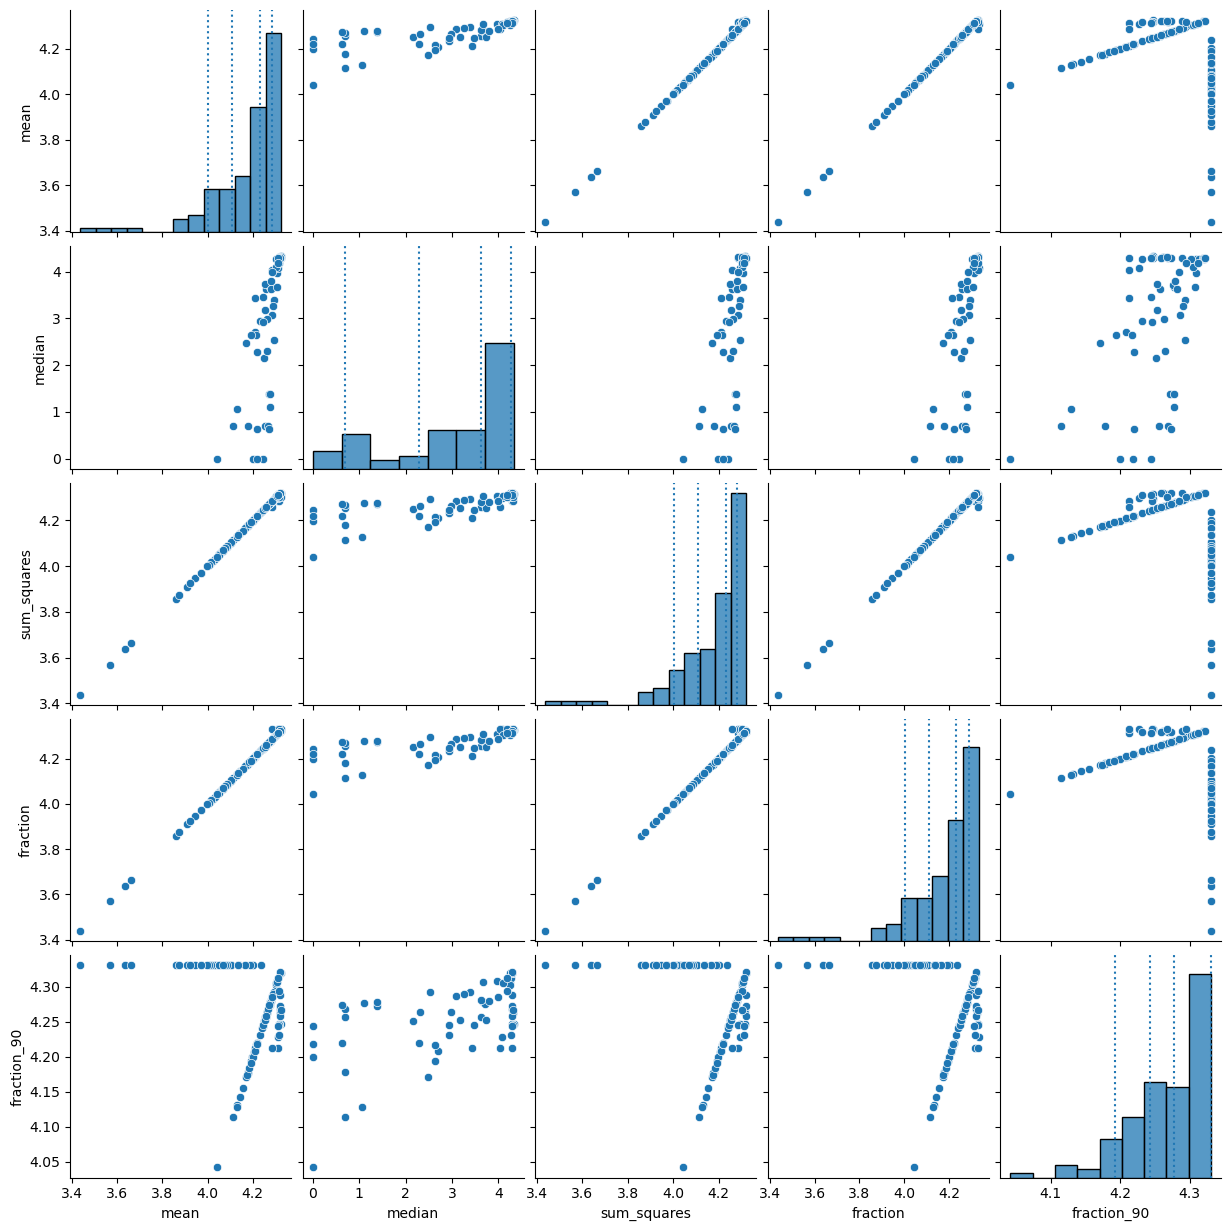

In [1030]:
sns.set_palette('tab10')
def update_diag_func(data, label, color):
    for val in data.quantile([0.1,.25, .5, .75]):
        plt.axvline(val, ls=':', color=color)
    # plt.title(data.name, color=color)

g = sns.pairplot(all_entropy)
g.map_diag(update_diag_func)

In [1029]:
gene_by_cluster_proportion_dict['SFRP1']

KeyError: 'SFRP1'

In [1003]:
shannon_entropy 

AKT1     4.308366
AXL      4.022383
BGN      4.208786
BIRC3    4.064111
BIRC5    4.257190
           ...   
VGF      4.128430
WNT5A    4.068626
YAP1     4.307156
ZEB1     4.136805
ZEB2     4.312248
Length: 119, dtype: float64

(array([ 1.,  1.,  2.,  0.,  2.,  5., 10., 16., 25., 57.]),
 array([3.43714514, 3.52649615, 3.61584715, 3.70519815, 3.79454916,
        3.88390016, 3.97325116, 4.06260217, 4.15195317, 4.24130417,
        4.33065518]),
 <BarContainer object of 10 artists>)

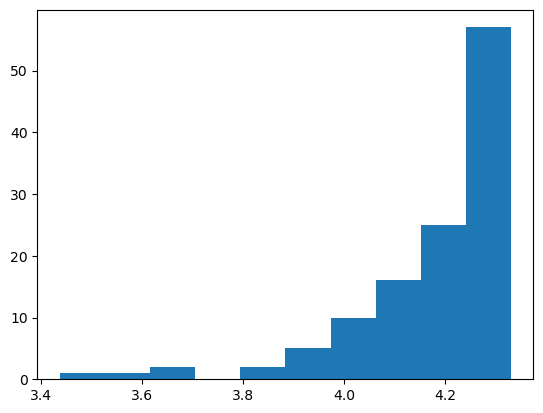

In [1004]:
plt.hist(shannon_entropy)

In [1005]:
shannon_entropy

AKT1     4.308366
AXL      4.022383
BGN      4.208786
BIRC3    4.064111
BIRC5    4.257190
           ...   
VGF      4.128430
WNT5A    4.068626
YAP1     4.307156
ZEB1     4.136805
ZEB2     4.312248
Length: 119, dtype: float64

In [1006]:
# shannon_entropy[shannon_entropy < shannon_entropy.quantile(0.25)].sort_values()
shannon_entropy[shannon_entropy < shannon_entropy.quantile(0.1)].sort_values()

ENSMUSG00000071361    3.437145
ITGA8                 3.568279
MMP1                  3.635930
ROR2                  3.662411
BMP2                  3.858163
NANOG                 3.875722
SFRP4                 3.910020
SLIT2                 3.924194
DKK3                  3.946160
VCAM1                 3.970372
NOTCH4                3.971633
RIGI                  3.999664
dtype: float64

In [1007]:
# shannon_entropy[shannon_entropy > shannon_entropy.quantile(0.85)].sort_values()
shannon_entropy[shannon_entropy > shannon_entropy.quantile(0.9)].sort_values()

TFAP2A     4.320074
CDKN1B     4.320284
SNAI2      4.321086
TGFB1      4.321310
CTNNB1     4.321480
CALD1      4.327108
FN1        4.329352
SOX10      4.329368
CCND1      4.329915
SPARC      4.330085
MT-RNR2    4.330154
L1CAM      4.330655
dtype: float64

In [1008]:
gene_by_cluster_proportion_dict['sum_squares']

8.0       10.0      16.0      26.0      28.0      31.0      39.0    \
AKT1   0.013454  0.014473  0.014479  0.015068  0.012939  0.014451  0.013423   
AXL    0.007062  0.000000  0.015706  0.013496  0.004049  0.006229  0.025169   
BGN    0.019928  0.007442  0.019489  0.005942  0.015558  0.010285  0.020182   
BIRC3  0.006637  0.015531  0.013121  0.011275  0.010147  0.013660  0.008139   
BIRC5  0.014669  0.018107  0.019600  0.015404  0.013309  0.014788  0.012974   
...         ...       ...       ...       ...       ...       ...       ...   
VGF    0.000766  0.006721  0.029526  0.023907  0.007904  0.014187  0.010038   
WNT5A  0.016781  0.016065  0.022620  0.015549  0.013995  0.014802  0.015435   
YAP1   0.009550  0.012238  0.013486  0.014099  0.015644  0.012702  0.011851   
ZEB1   0.001654  0.008708  0.019618  0.017910  0.017067  0.013858  0.008366   
ZEB2   0.008935  0.013068  0.014352  0.013123  0.014799  0.012697  0.011015   

         42.0      49.0      55.0    ...    1214.0    1254.0    1315.0  \
AKT1   0.015467  0.013103  0.008840  ...  0.013481  0.008428  0.013437   
AXL    0.020798  0.006461  0.003995  ...  0.012489  0.000000  0.036438   
BGN    0.004246  0.010861  0.011995  ...  0.017248  0.015291  0.021878   
BIRC3  0.015638  0.008096  0.005007  ...  0.015651  0.000000  0.030441   
BIRC5  0.014243  0.008849  0.004378  ...  0.012901  0.003578  0.015527   
...         ...       ...       ...  ...       ...       ...       ...   
VGF    0.023910  0.008408  0.007800  ...  0.008127  0.002125  0.007904   
WNT5A  0.023364  0.016749  0.006905  ...  0.016189  0.008464  0.000000   
YAP1   0.011072  0.018861  0.007204  ...  0.014678  0.010934  0.009386   
ZEB1   0.021432  0.015131  0.000000  ...  0.008775  0.000000  0.011378   
ZEB2   0.012865  0.016803  0.005617  ...  0.011029  0.012393  0.011099   

         1383.0    1394.0    1408.0    1510.0    1534.0    1590.0    3176.0  
AKT1   0.016589  0.010017  0.013244  0.010049  0.014406  0.014801  0.015163  
AXL    0.011246  0.017862  0.019590  0.023358  0.005327  0.000000  0.025304  
BGN    0.002701  0.024398  0.009410  0.014024  0.015993  0.015088  0.003039  
BIRC3  0.014093  0.005596  0.012275  0.019514  0.006676  0.013121  0.007927  
BIRC5  0.017458  0.015902  0.018783  0.009242  0.013134  0.013385  0.014441  
...         ...       ...       ...       ...       ...       ...       ...  
VGF    0.012197  0.004843  0.019122  0.001689  0.006933  0.011356  0.026072  
WNT5A  0.000000  0.019294  0.000000  0.013456  0.009207  0.000000  0.054666  
YAP1   0.011588  0.013995  0.010934  0.011365  0.011435  0.016183  0.015752  
ZEB1   0.026339  0.010458  0.013764  0.025528  0.004990  0.009809  0.011852  
ZEB2   0.015811  0.014125  0.012393  0.014229  0.016851  0.015456  0.015119  

[119 rows x 76 columns]

In [1013]:
gene_by_cluster_proportion_dict['fraction_50']

8.0       10.0      16.0      26.0      28.0      31.0      39.0    \
AKT1   0.013454  0.014473  0.014479  0.015068  0.012939  0.014451  0.013423   
AXL    0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158   
BGN    0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158   
BIRC3  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158   
BIRC5  0.014669  0.018107  0.019600  0.015404  0.013309  0.014788  0.012974   
...         ...       ...       ...       ...       ...       ...       ...   
VGF    0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158   
WNT5A  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158   
YAP1   0.009550  0.012238  0.013486  0.014099  0.015644  0.012702  0.011851   
ZEB1   0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158   
ZEB2   0.008935  0.013068  0.014352  0.013123  0.014799  0.012697  0.011015   

         42.0      49.0      55.0    ...    1214.0    1254.0    1315.0  \
AKT1   0.015467  0.013103  0.008840  ...  0.013481  0.008428  0.013437   
AXL    0.013158  0.013158  0.013158  ...  0.013158  0.013158  0.013158   
BGN    0.013158  0.013158  0.013158  ...  0.013158  0.013158  0.013158   
BIRC3  0.013158  0.013158  0.013158  ...  0.013158  0.013158  0.013158   
BIRC5  0.014243  0.008849  0.004378  ...  0.012901  0.003578  0.015527   
...         ...       ...       ...  ...       ...       ...       ...   
VGF    0.013158  0.013158  0.013158  ...  0.013158  0.013158  0.013158   
WNT5A  0.013158  0.013158  0.013158  ...  0.013158  0.013158  0.013158   
YAP1   0.011072  0.018861  0.007204  ...  0.014678  0.010934  0.009386   
ZEB1   0.013158  0.013158  0.013158  ...  0.013158  0.013158  0.013158   
ZEB2   0.012865  0.016803  0.005617  ...  0.011029  0.012393  0.011099   

         1383.0    1394.0    1408.0    1510.0    1534.0    1590.0    3176.0  
AKT1   0.016589  0.010017  0.013244  0.010049  0.014406  0.014801  0.015163  
AXL    0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  
BGN    0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  
BIRC3  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  
BIRC5  0.017458  0.015902  0.018783  0.009242  0.013134  0.013385  0.014441  
...         ...       ...       ...       ...       ...       ...       ...  
VGF    0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  
WNT5A  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  
YAP1   0.011588  0.013995  0.010934  0.011365  0.011435  0.016183  0.015752  
ZEB1   0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  0.013158  
ZEB2   0.015811  0.014125  0.012393  0.014229  0.016851  0.015456  0.015119  

[119 rows x 76 columns]

Text(0, 0.5, 'Proportion of median expression from each cluster')

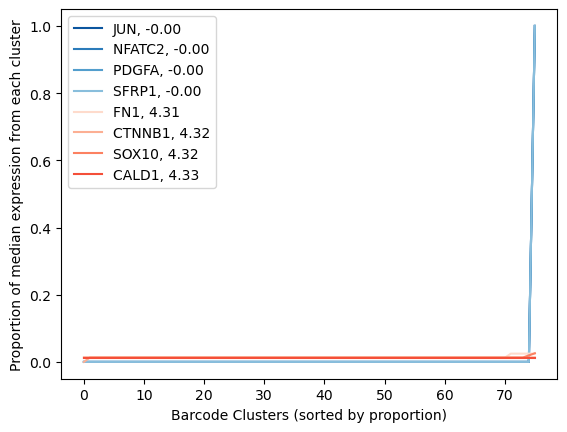

In [1035]:
# gene_list = ['IGFBP7','VEGFA','MITF','IFIT2','ITGA8','ROR2','SOX10','MMP1','BMP2','SFRP1']
# gene_list = ['MMP1','ENSMUSG00000071361','DCN','SFRP1','SOX10','MITF']

how = 'mean'

# how = 'fraction_90'
how = 'sum_squares'
how = 'median'

gene_list = list(all_entropy[all_entropy[how] < all_entropy[how].quantile(0.05)].sort_values(how).index)

# sns.set_palette('Blues',6)
colors = sns.color_palette('Blues_r',6)

for gene in gene_list:
    plt.plot(sorted(gene_by_cluster_proportion_dict[how].loc[gene]),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

gene_list = list(all_entropy[all_entropy[how] > all_entropy[how].quantile(0.95)].sort_values(how).index)

# sns.set_palette('Greys',6)
colors = sns.color_palette('Reds',6)

for gene in gene_list:
    plt.plot(sorted(gene_by_cluster_proportion_dict[how].loc[gene]),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

plt.legend()
plt.xlabel('Barcode Clusters (sorted by proportion)')
plt.ylabel(f'Proportion of {how} expression from each cluster')


Text(0, 0.5, 'Mean mean expression from each cluster')

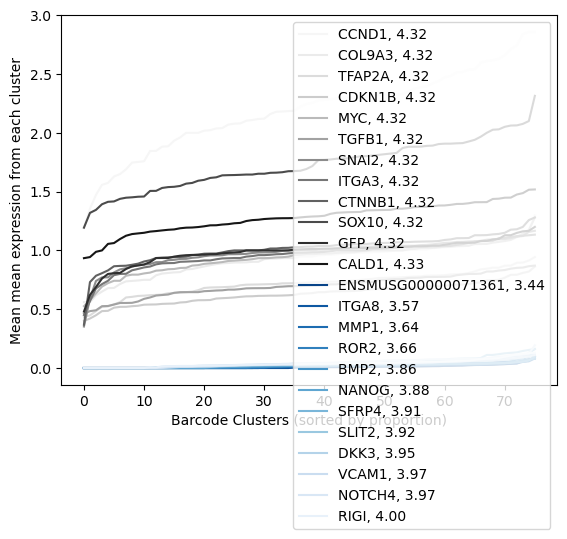

In [1061]:
# gene_list = ['IGFBP7','VEGFA','MITF','IFIT2','ITGA8','ROR2','SOX10','MMP1','BMP2','SFRP1']
# gene_list = ['MMP1','ENSMUSG00000071361','DCN','SFRP1','SOX10','MITF']

how = 'mean'
# how = 'fraction_50'

def to_z_score(data):
    return (data - data.mean())/data.std()

gene_list = list(all_entropy[all_entropy[how] > all_entropy[how].quantile(0.9)].sort_values(how).index)

# sns.set_palette('Greys',6)
colors = sns.color_palette('Greys',len(gene_list))

for gene in gene_list:
    plt.plot(sorted(gene_by_cluster_measure_dict[how].loc[gene]),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

gene_list = list(all_entropy[all_entropy[how] < all_entropy[how].quantile(0.1)].sort_values(how).index)

# sns.set_palette('Blues',6)
colors = sns.color_palette('Blues_r',len(gene_list))

for gene in gene_list:
    plt.plot(sorted(gene_by_cluster_measure_dict[how].loc[gene]),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

plt.legend()
plt.xlabel('Barcode Clusters (sorted by proportion)')
plt.ylabel(f'Mean {how} expression from each cluster')


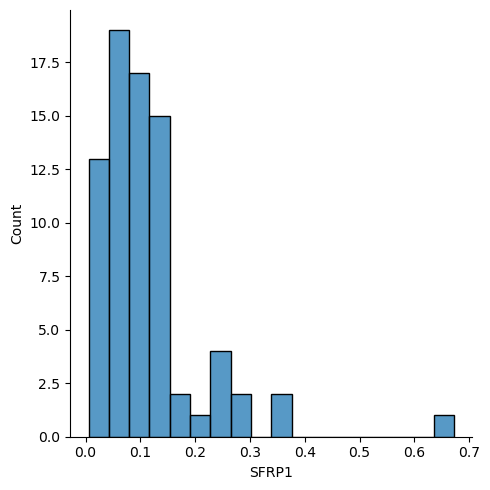

In [1063]:
gene = 'SFRP1'
how = 'mean'

sns.displot(gene_by_cluster_measure_dict[how].loc[gene])

In [1023]:
all_entropy[all_entropy[how] >= all_entropy[how].quantile(0.95)]

mean   median  sum_squares  fraction  fraction_50   gene
AXL    4.022383      NaN     4.022383  4.022383     4.330733    AXL
BGN    4.208786  2.70805     4.208786  4.208786     4.330733    BGN
BIRC3  4.064111      NaN     4.064111  4.064111     4.330733  BIRC3
BMP2   3.858163      NaN     3.858163  3.858163     4.330733   BMP2
BMP4   4.101849      NaN     4.101849  4.101849     4.330733   BMP4
...         ...      ...          ...       ...          ...    ...
VCAM1  3.970372      NaN     3.970372  3.970372     4.330733  VCAM1
VEGFC  4.077707      NaN     4.077707  4.077707     4.330733  VEGFC
VGF    4.128430  1.05492     4.128430  4.128430     4.330733    VGF
WNT5A  4.068626      NaN     4.068626  4.068626     4.330733  WNT5A
ZEB1   4.136805      NaN     4.136805  4.136805     4.330733   ZEB1

[86 rows x 6 columns]

Text(0, 0.5, 'Z-score of mean expression from each cluster')

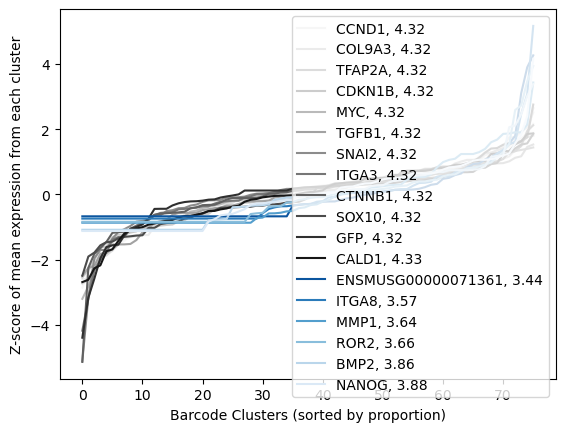

In [1060]:
# gene_list = ['IGFBP7','VEGFA','MITF','IFIT2','ITGA8','ROR2','SOX10','MMP1','BMP2','SFRP1']
# gene_list = ['MMP1','ENSMUSG00000071361','DCN','SFRP1','SOX10','MITF']

how = 'mean'
# how = 'fraction_90'

def to_z_score(data):
    return (data - data.mean())/data.std()

gene_list = list(all_entropy[all_entropy[how] > all_entropy[how].quantile(0.9)].sort_values(how).index)

# sns.set_palette('Greys',6)
colors = sns.color_palette('Greys',len(gene_list))

for gene in gene_list:
    plt.plot(sorted(to_z_score(gene_by_cluster_measure_dict[how].loc[gene])),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

gene_list = list(all_entropy[all_entropy[how] < all_entropy[how].quantile(0.05)].sort_values(how).index)

# sns.set_palette('Blues',6)
colors = sns.color_palette('Blues_r',6)

for gene in gene_list:
    plt.plot(sorted(to_z_score(gene_by_cluster_measure_dict[how].loc[gene])),label=f'{gene}, {all_entropy[how][gene]:.2f}',color=colors[gene_list.index(gene)])

plt.legend()
plt.xlabel('Barcode Clusters (sorted by proportion)')
plt.ylabel(f'Z-score of {how} expression from each cluster')


In [434]:
gene_of_interest = 'MMP1'
gene_of_interest = 'MMP1'

(gene_by_bc_cluster_proportion.loc['MMP1'])[gene_by_bc_cluster_proportion.loc['MMP1'] > 0.05]


(gene_by_bc_cluster_proportion.loc['MMP1'])[gene_by_bc_cluster_proportion.loc['MMP1'] > 0.05]

10.0     0.050732
16.0     0.058932
97.0     0.179129
372.0    0.054851
511.0    0.130835
Name: MMP1, dtype: float64

In [1043]:
gene_of_interest = 'OASL'
# gene_of_interest = 'VGF'

# (gene_by_bc_cluster_proportion.loc[gene_of_interest ])[gene_by_bc_cluster_proportion.loc[gene_of_interest ] > 0.03].index
(gene_by_bc_cluster_proportion.loc[gene_of_interest ]).sort_values(ascending=False).head(10)


8.0      0.013158
632.0    0.013158
846.0    0.013158
756.0    0.013158
753.0    0.013158
746.0    0.013158
684.0    0.013158
651.0    0.013158
644.0    0.013158
617.0    0.013158
Name: OASL, dtype: float64

In [738]:
(gene_by_bc_cluster_proportion.loc[gene_of_interest ]).sort_values(ascending=False)

175.0     0.050093
1590.0    0.048366
1315.0    0.044884
651.0     0.027147
894.0     0.027147
            ...   
746.0     0.000000
195.0     0.000000
250.0     0.000000
335.0     0.000000
356.0     0.000000
Name: OASL, Length: 76, dtype: float64

In [739]:
merged_gdf = sg_obj.gdf.merge(cell_gene_table_df, on='object_id', how='left')

In [740]:
props = (gene_by_bc_cluster_proportion.loc['FOSB']).sort_values(ascending=False).values



In [741]:
np.sum(props>0.1)

0

In [771]:
all_entropy

mean    median  sum_squares  fraction   gene
AKT1   4.237382  4.173895     4.107925  4.308366   AKT1
AXL    3.960897       NaN     3.690168  4.022383    AXL
BGN    4.028416  2.497823     3.596759  4.208786    BGN
BIRC3  4.012317       NaN     3.416540  4.064111  BIRC3
BIRC5  4.194568  3.617826     4.073135  4.257190  BIRC5
...         ...       ...          ...       ...    ...
VGF    3.801361  1.054920     3.003579  4.128430    VGF
WNT5A  4.059885       NaN     4.028778  4.068626  WNT5A
YAP1   4.273389  3.662854     4.192171  4.307156   YAP1
ZEB1   4.124189       NaN     4.074104  4.136805   ZEB1
ZEB2   4.279682  4.169278     4.198519  4.312248   ZEB2

[119 rows x 5 columns]

In [774]:
# all_entropy['sum_squares'].loc['SFRP1','sum_squares']

gene_by_cluster_proportion_dict['sum_squares'].loc['SFRP1']

8.0       0.005961
10.0      0.001141
16.0      0.682670
26.0      0.005109
28.0      0.003977
            ...   
1408.0    0.001203
1510.0    0.000956
1534.0    0.007195
1590.0    0.001286
3176.0    0.003107
Name: SFRP1, Length: 76, dtype: float64

16.0      0.078440
195.0     0.042072
155.0     0.039769
49.0      0.034748
431.0     0.031528
            ...   
55.0      0.003070
846.0     0.002916
746.0     0.001477
1101.0    0.001261
256.0     0.000641
Name: SFRP1, Length: 76, dtype: float64
16 58 ['28140', '28279', '28729', '30256', '30446', '30561', '30762', '30823', '30807', '31023', '31084', '31076', '31476', '31595', '31648', '31749', '31632', '31665', '31816', '31860', '32300', '32342', '32452', '32534', '32536', '32578', '32852', '32881', '32762', '32817', '32873', '32960', '33102', '33160', '33206', '33174', '33204', '33256', '33239', '33406', '33482', '33565', '33547', '33515', '33599', '33669', '33640', '33642', '33629', '33780', '33911', '33871', '33990', '34141', '34203', '34375', '34772', '36023']
['bc_001' 'bc_003' 'bc_004' 'bc_006' 'bc_007' 'bc_008' 'bc_009' 'bc_010'
 'bc_014' 'bc_016' 'bc_022' 'bc_024' 'bc_027' 'bc_029' 'bc_031' 'bc_033'
 'bc_035' 'bc_039' 'bc_040' 'bc_041' 'bc_044' 'bc_048' 'bc_052' 'bc_056'
 'b

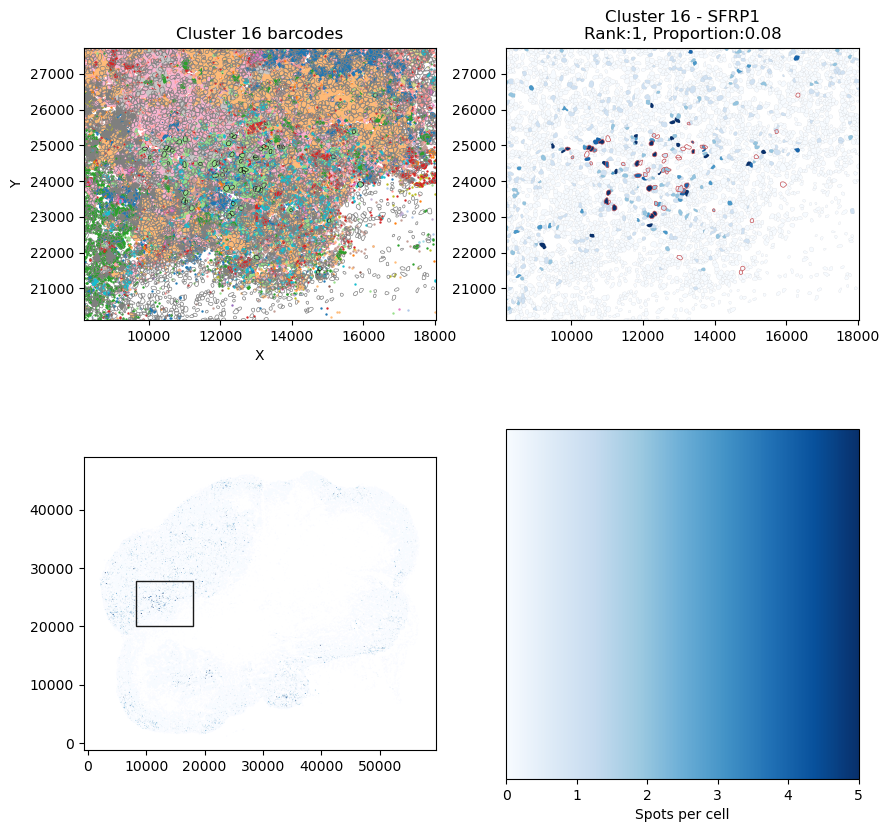

In [1058]:
gene_of_interest = 'SFRP1'
how = 'fraction_90'

print((gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False))
# clusters_of_interest = [int(x) for x in (gene_by_bc_cluster_proportion.loc[gene_of_interest ])[gene_by_bc_cluster_proportion.loc[gene_of_interest ] > 0.05].index]

top_to_plot = 1
threshold = 0.02

props = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values

top_to_plot = min([sum(props>threshold),top_to_plot])

clusters_of_interest = [int(x) for x in (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).index[:top_to_plot]]
proportions_of_interest = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values[:top_to_plot]

for rank,(cluster_of_interest,proportion) in enumerate(zip(clusters_of_interest,proportions_of_interest)): 

    cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)
    print(cluster_of_interest,len(cluster_cells),cluster_cells)

    central_ix = int(len(cluster_cells)/2)

    cell_id = cluster_cells[central_ix]

    region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

    sg_obj.gdf['object_id'] = sg_obj.gdf.index

    gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')

    print(np.unique(gene_names))

    fig = plt.figure(figsize=(10,10))

    vmin = 0
    vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])

    ax = fig.add_subplot(221)
    tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
                                annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
                                focal_outline_color='k',other_outline_color='gray',
                                interior_marker='.',single_mode=False,lw=0.5,
                                exterior_marker='.',marker_size=2,ax=ax)

    plt.title(f'Cluster {cluster_of_interest} barcodes')

    ymin,ymax = plt.ylim()
    xmin,xmax = plt.xlim()

    ax = fig.add_subplot(223)

    merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=False,vmin=vmin,vmax=vmax,ax=ax)

    rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    ax = fig.add_subplot(224)

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Blues',
                                norm=norm,
                                orientation='horizontal')
    cb1.set_label('Spots per cell')
    
    ax = fig.add_subplot(222)

    gene_names = [gene_of_interest]

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    # tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
    #                             annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
    #                             focal_outline_color='r',other_outline_color='gray',
    #                             interior_marker='.',single_mode=False,lw=0.5,
    #                             exterior_marker='.',marker_size=2,ax=ax)

    plt.title(f'Cluster {cluster_of_interest} - {gene_of_interest}\nRank:{rank+1}, Proportion:{proportion:.2f}')

    vmin = 0
    vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
    print('VRange',vmin,vmax)

    # other_clusters = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

    bbox = box(xmin,ymin,xmax,ymax)

    other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

    sg_obj.gdf = sg_obj.gdf.drop(columns=['object_id'])

    merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters.index)]

    # print(merged_gdf_focal.shape)

    merged_gdf_other.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]

    merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs.index)]
    
    print(merged_gdf_focal.shape)
    merged_gdf_focal.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5)

    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)

    plt.savefig(f'plots/cluster_intrinsic_expression_{how}_{gene_of_interest}_{cluster_of_interest}.pdf',bbox_inches='tight')
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

In [1049]:
adata_genes.obs['bc_cluster'].value_counts()

311.0     1388
372.0     1150
159.0      653
179.0      542
398.0      440
          ... 
1931.0       1
385.0        1
2544.0       1
2275.0       1
987.0        1
Name: bc_cluster, Length: 3396, dtype: int64

<AxesSubplot: >

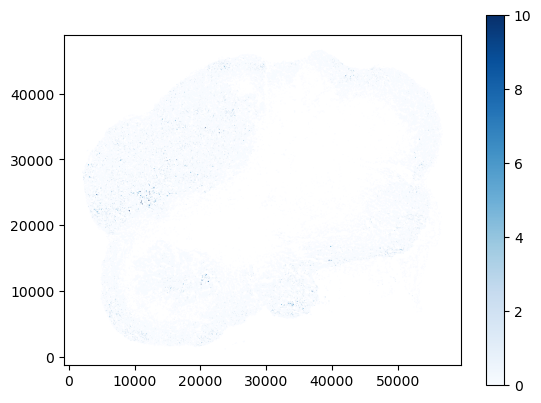

In [1046]:
gene_of_interest = 'SFRP1'
how = 'fraction_90'

print((gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False))
# clusters_of_interest = [int(x) for x in (gene_by_bc_cluster_proportion.loc[gene_of_interest ])[gene_by_bc_cluster_proportion.loc[gene_of_interest ] > 0.05].index]

top_to_plot = 1
threshold = 0.02

props = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values

top_to_plot = min([sum(props>threshold),top_to_plot])

clusters_of_interest = [int(x) for x in (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).index[:top_to_plot]]
proportions_of_interest = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values[:top_to_plot]

for rank,(cluster_of_interest,proportion) in enumerate(zip(clusters_of_interest,proportions_of_interest)): 

    vmin = 0
    vmax = 10

    fig,ax = plt.figure(figsize=(10,5))

    plt.subplot(222)
    merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=True,vmin=vmin,vmax=vmax)

    plt.subplot(221)
    merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=True,vmin=vmin,vmax=vmax)



<AxesSubplot: >

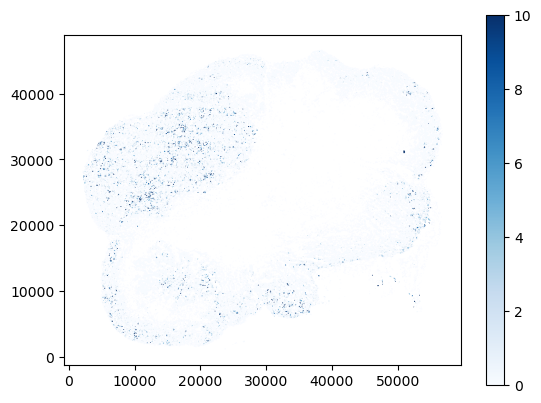

In [1052]:
merged_gdf.plot(column='VGF', cmap='Blues',vmax=10, legend=True)

In [482]:
adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs.index
merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs.index)]

In [523]:
extrinsic_entropy = pd.read_csv('extrinsic_entropy_per_gene.csv',names=['gene','extrinsic_entropy','extrinsic_entropy_normalized'],header=0)

In [524]:
extrinsic_entropy

gene  extrinsic_entropy  extrinsic_entropy_normalized
0     AKT1           4.632635                      0.951262
1      AXL           4.633513                      0.955385
2      BGN           4.634087                      0.958082
3    BIRC3           4.613684                      0.862225
4    BIRC5           4.632632                      0.951245
..     ...                ...                           ...
114    VGF           4.606448                      0.828227
115  WNT5A           4.611884                      0.853768
116   YAP1           4.640377                      0.987634
117   ZEB1           4.631993                      0.948242
118   ZEB2           4.636038                      0.967249

[119 rows x 3 columns]

In [527]:
shannon_entropy

intrinsic_entropy = pd.DataFrame(shannon_entropy,columns=['intrinsic_entropy'])
intrinsic_entropy['gene'] = intrinsic_entropy.index
intrinsic_entropy['intrinsic_entropy_normalized'] = (intrinsic_entropy['intrinsic_entropy']-intrinsic_entropy['intrinsic_entropy'].min())/(intrinsic_entropy['intrinsic_entropy'].max()-intrinsic_entropy['intrinsic_entropy'].min())

all_entropy = pd.merge(extrinsic_entropy,intrinsic_entropy,on='gene')

Text(0, 0.5, 'Extrinsic Score (1-normalized)')

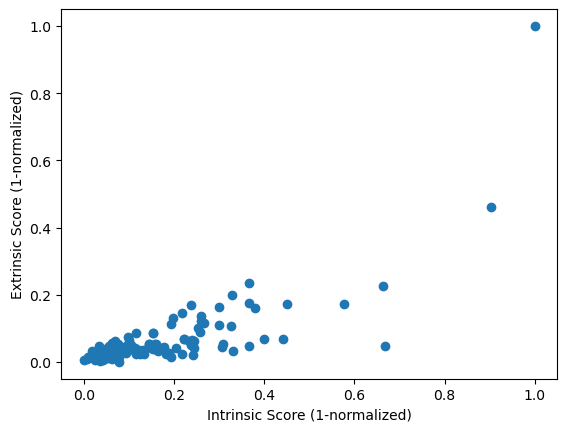

In [546]:
plt.scatter(1-all_entropy['intrinsic_entropy_normalized'],1-all_entropy['extrinsic_entropy_normalized'])
plt.xlabel('Intrinsic Score (1-normalized)')
plt.ylabel('Extrinsic Score (1-normalized)')
# plt.yscale('log')
# plt.xscale('log')

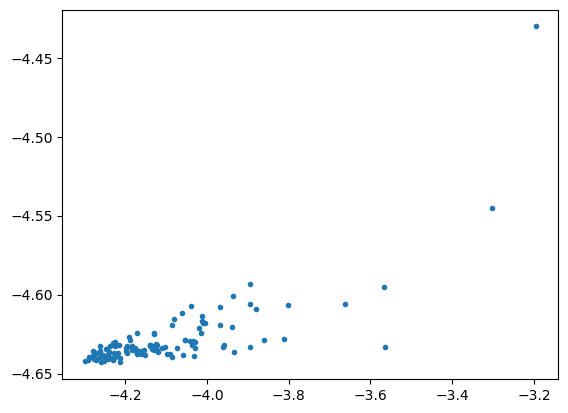

In [547]:
plt.scatter(-all_entropy['intrinsic_entropy'],-all_entropy['extrinsic_entropy'],marker='.')
# plt.xlabel('Intrinsic Score (1-normalized)')
# plt.ylabel('Extrinsic Score (1-normalized)')
# plt.yscale('log')
# plt.xscale('log')

In [555]:
all_entropy['intrinsic_percentile'] = all_entropy['intrinsic_entropy'].rank(pct=True)
all_entropy['extrinsic_percentile'] = all_entropy['extrinsic_entropy'].rank(pct=True)

all_entropy['intrinsic_z'] = (all_entropy['intrinsic_entropy']-all_entropy['intrinsic_entropy'].median())/all_entropy['intrinsic_entropy'].std()
all_entropy['extrinsic_z'] = (all_entropy['extrinsic_entropy']-all_entropy['extrinsic_entropy'].median())/all_entropy['extrinsic_entropy'].std()

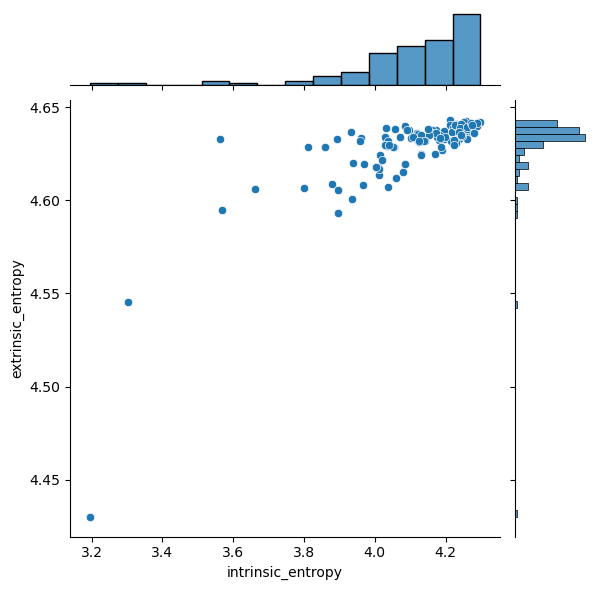

In [592]:
sns.jointplot(all_entropy,x='intrinsic_entropy',y='extrinsic_entropy')
# label outlier genes in 25th percentile of intrinsic entropy of either entropy measure
outliers = all_entropy[(all_entropy['intrinsic_entropy'] < all_entropy['intrinsic_entropy'].quantile(0.15)) | (all_entropy['extrinsic_entropy'] < all_entropy['extrinsic_entropy'].quantile(0.15))]

# for i in outliers.index:
#     plt.text(all_entropy.loc[i,'intrinsic_entropy'],all_entropy.loc[i,'extrinsic_entropy'],all_entropy.loc[i,'gene'])

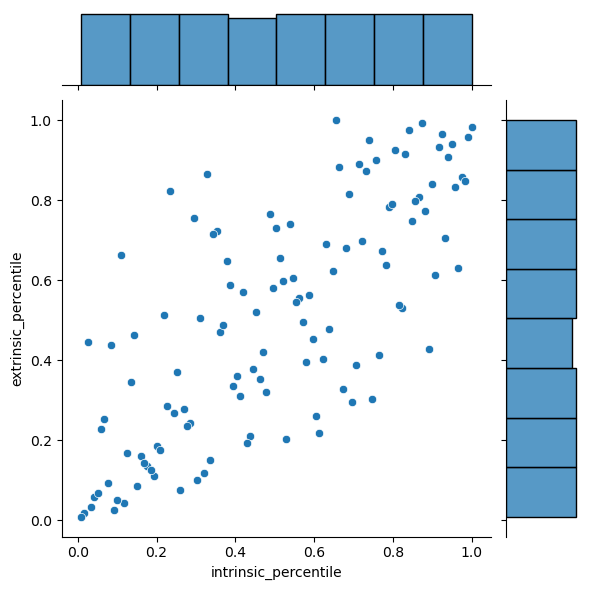

In [552]:
sns.jointplot(all_entropy,x='intrinsic_percentile',y='extrinsic_percentile')
# label outlier genes in 25th percentile of intrinsic entropy of either entropy measure
outliers = all_entropy[(all_entropy['intrinsic_entropy'] < all_entropy['intrinsic_entropy'].quantile(0.15)) | (all_entropy['extrinsic_entropy'] < all_entropy['extrinsic_entropy'].quantile(0.15))]

# for i in outliers.index:
#     plt.text(all_entropy.loc[i,'intrinsic_percentile'],all_entropy.loc[i,'extrinsic_percentile'],all_entropy.loc[i,'gene'])

In [585]:
sns.set_color_codes('deep')

([Text(-0.8411322373952936, 0.9957996707323975, 'AXL'),
  Text(-1.801675986802314, 0.043870720530735596, 'BMP2'),
  Text(-1.6009172343448634, 0.5499352660417625, 'COL1A1'),
  Text(-0.38689633272536117, -0.9477200057884136, 'DCN'),
  Text(-0.7427587854713815, -0.2824355587843197, 'DKK3'),
  Text(-3.242420187909678, -3.6995532587460866, 'ENSMUSG00000071361'),
  Text(-0.7666183236438959, 0.5079801249158873, 'FOSB'),
  Text(-1.1723957591637575, -2.774832195351653, 'IFIT2'),
  Text(-0.7997540702497448, 1.8074765413762748, 'IGFBP7'),
  Text(-2.8655089987622437, -1.7918255215028438, 'ITGA8'),
  Text(-4.902596382736785, -8.893286963267084, 'MMP1'),
  Text(-1.3586296553942478, -0.8683933424754873, 'NANOG'),
  Text(-0.5457042755889336, 0.08941184650686296, 'NOTCH4'),
  Text(-0.8922422860059527, -2.307556683447144, 'OASL'),
  Text(-2.382175648532864, -1.2991959335279706, 'ROR2'),
  Text(-2.8730788133002934, 0.1257439758784642, 'SFRP1'),
  Text(-0.943541390934322, -1.8081933444793012, 'SFRP4'),
  

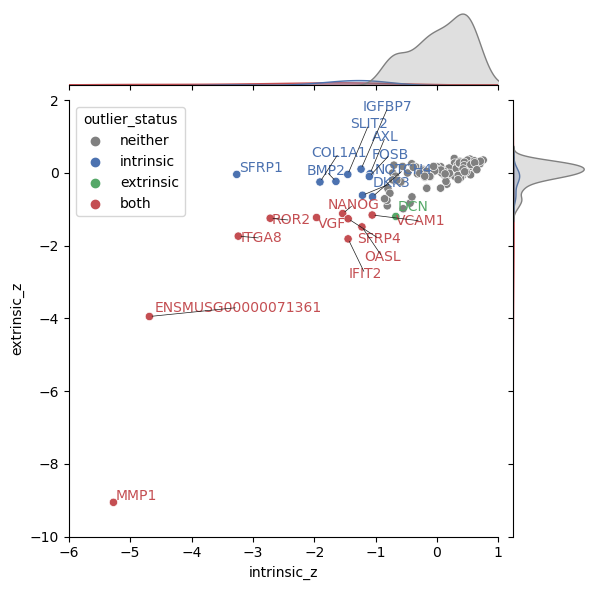

In [600]:
intrinsic_outliers = all_entropy[(all_entropy['intrinsic_z'] < -1)]
extrinsic_outliers = all_entropy[(all_entropy['extrinsic_z'] < -1)]

all_entropy['outlier_status'] = ['both' if (i in intrinsic_outliers.index and i in extrinsic_outliers.index) else 'intrinsic' if i in intrinsic_outliers.index else 'extrinsic' if i in extrinsic_outliers.index else 'neither' for i in all_entropy.index]

color_map = {'both':'r','intrinsic':'b','extrinsic':'g','neither':'gray'}


sns.jointplot(all_entropy,x='intrinsic_z',y='extrinsic_z',hue='outlier_status',palette=color_map,marker='o')
# label outlier genes in 25th percentile of intrinsic entropy of either entropy measure
outliers = all_entropy[(all_entropy['intrinsic_z'] < -1) | (all_entropy['extrinsic_z'] < -1)]

plt.xlim(-6,1)
plt.ylim(-10,2)

texts = []
for i in outliers.index:
    texts.append(plt.text(all_entropy.loc[i,'intrinsic_z'],all_entropy.loc[i,'extrinsic_z'],all_entropy.loc[i,'gene'],c=color_map[all_entropy.loc[i,'outlier_status']]))

adjust_text(texts,autoalign='y',
            only_move={'points':'y', 'text':'y'}, force_points=0.5,
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5))


In [593]:
all_entropy[all_entropy['outlier_status']!='neither'].sort_values('intrinsic_entropy')

gene  extrinsic_entropy  extrinsic_entropy_normalized  \
59                 MMP1           4.430163                      0.000000   
22   ENSMUSG00000071361           4.545182                      0.540386   
90                SFRP1           4.633120                      0.953540   
44                ITGA8           4.594920                      0.774067   
85                 ROR2           4.606006                      0.826150   
114                 VGF           4.606448                      0.828227   
15               COL1A1           4.628431                      0.931509   
5                  BMP2           4.628802                      0.933253   
66                NANOG           4.608892                      0.839711   
93                SLIT2           4.633119                      0.953535   
38                IFIT2           4.593223                      0.766096   
91                SFRP4           4.605692                      0.824677   
39               IGFBP7           4.636395                      0.968926   
75                 OASL           4.600644                      0.800960   
20                 DKK3           4.620221                      0.892939   
29                 FOSB           4.631819                      0.947428   
1                   AXL           4.633513                      0.955385   
111               VCAM1           4.607995                      0.835496   
72               NOTCH4           4.619305                      0.888635   
19                  DCN           4.607107                      0.831325   

     intrinsic_entropy  intrinsic_entropy_normalized  intrinsic_percentile  \
59            3.195451                      0.000000              0.008403   
22            3.302693                      0.097209              0.016807   
90            3.563314                      0.333448              0.025210   
44            3.567870                      0.337578              0.033613   
85            3.663078                      0.423879              0.042017   
114           3.801361                      0.549225              0.050420   
15            3.811530                      0.558442              0.058824   
5             3.859243                      0.601692              0.067227   
66            3.879386                      0.619951              0.075630   
93            3.894602                      0.633743              0.084034   
38            3.895466                      0.634526              0.092437   
91            3.895716                      0.634753              0.100840   
39            3.934163                      0.669603              0.109244   
75            3.936808                      0.672001              0.117647   
20            3.938445                      0.673484              0.126050   
29            3.958877                      0.692005              0.134454   
1             3.960897                      0.693836              0.142857   
111           3.967386                      0.699718              0.151261   
72            3.968371                      0.700611              0.159664   
19            4.037912                      0.763646              0.260504   

     extrinsic_percentile  intrinsic_z  extrinsic_z outlier_status  
59               0.008403    -5.272290    -9.058307           both  
22               0.016807    -4.686569    -3.947083           both  
90               0.445378    -3.263142    -0.039276      intrinsic  
44               0.033613    -3.238258    -1.736819           both  
85               0.058824    -2.718261    -1.244189           both  
114              0.067227    -1.963005    -1.224548           both  
15               0.226891    -1.907468    -0.247662      intrinsic  
5                0.252101    -1.646873    -0.231163      intrinsic  
66               0.092437    -1.536857    -1.115924           both  
93               0.436975    -1.453752    -0.039322      intrinsic  
38               0.02521

In [595]:
from adjustText import adjust_text

In [607]:
sc.metrics.morans_i(adata_genes,use_raw=True)

ValueError: Must run neighbors first.

In [608]:
import squidpy as sq

In [609]:
sq.gr.spatial_neighbors(adata_genes)

KeyError: 'Spatial basis `spatial` not found in `adata.obsm`.'